In [153]:
import sys
import os 
import numpy as np
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.sampling.sampler import get_polarisation_curve_samples, build_fixed_parameters, sample_parameters, PARAMETER_RANGES
from configuration.settings import current_density_parameters, physical_parameters, computing_parameters, operating_inputs
from modules.display_modules import plot_lambda
from model.AlphaPEM import AlphaPEM


In [10]:
PARAMETER_RANGES

{'Tfc': (333, 363),
 'Pa_des': (130000.0, 300000.0),
 'Pc_des': None,
 'Sc': (1.1, 3),
 'Phi_c_des': (0.1, 0.7),
 'epsilon_gdl': (0.55, 0.8),
 'tau': (1.0, 4.0),
 'epsilon_mc': (0.15, 0.4),
 'epsilon_c': (0.15, 0.3),
 'e': [3, 4, 5],
 'Re': (5e-07, 5e-06),
 'i0_c_ref': (0.001, 500),
 'kappa_co': (0.01, 40),
 'kappa_c': (0, 100),
 'a_slim': (0, 1),
 'b_slim': (0, 1),
 'a_switch': (0, 1)}

In [31]:
param_grids = {}
for param, bounds in PARAMETER_RANGES.items():
    if isinstance(bounds, tuple):
        grid = np.linspace(bounds[0], bounds[1], num=20) 
    elif isinstance(bounds, list):
        grid = bounds
    param_grids[param] = grid

In [3]:
param_grids

{'Tfc': array([333.        , 334.57894737, 336.15789474, 337.73684211,
        339.31578947, 340.89473684, 342.47368421, 344.05263158,
        345.63157895, 347.21052632, 348.78947368, 350.36842105,
        351.94736842, 353.52631579, 355.10526316, 356.68421053,
        358.26315789, 359.84210526, 361.42105263, 363.        ]),
 'Pa_des': array([130000.        , 138947.36842105, 147894.73684211, 156842.10526316,
        165789.47368421, 174736.84210526, 183684.21052632, 192631.57894737,
        201578.94736842, 210526.31578947, 219473.68421053, 228421.05263158,
        237368.42105263, 246315.78947368, 255263.15789474, 264210.52631579,
        273157.89473684, 282105.26315789, 291052.63157895, 300000.        ]),
 'Pc_des': array([130000.        , 138947.36842105, 147894.73684211, 156842.10526316,
        165789.47368421, 174736.84210526, 183684.21052632, 192631.57894737,
        201578.94736842, 210526.31578947, 219473.68421053, 228421.05263158,
        237368.42105263, 246315.78947368,

In [5]:
len(param_grids)

17

In [4]:
default_values = {'Tfc': 347.15,
 'Pa_des': 2.5e5,
 'Pc_des': 2.5e5,
 'Sa': 1.2,
 'Sc': 2,
 'Phi_a_des': 0.4,
 'Phi_c_des': 0.6,
 'epsilon_gdl': 0.701,
 'tau': 1.02,
 'epsilon_mc': 0.399,
 'epsilon_c': 0.271,
 'e': 5,
 'Re': 5.7e-7,
 'i0_c_ref': 2.79,
 'kappa_co': 27.2,
 'kappa_c': 1.61,
 'a_slim': 0.056,
 'b_slim': 0.105,
 'a_switch': 0.637}

In [6]:
param_grids = {'Sc': param_grids['Sc'], 'Phi_c_des': param_grids['Phi_c_des']}

In [7]:
len(param_grids)

2

In [8]:
# Build DataFrame by varying one parameter at a time
rows = []
for param, grid in param_grids.items():
    for value in grid:
        row = default_values.copy()
        row[param] = value
        rows.append(row)


In [9]:
rows

[{'Tfc': 347.15,
  'Pa_des': 250000.0,
  'Pc_des': 250000.0,
  'Sa': 1.2,
  'Sc': np.float64(1.1),
  'Phi_a_des': 0.4,
  'Phi_c_des': 0.6,
  'epsilon_gdl': 0.701,
  'tau': 1.02,
  'epsilon_mc': 0.399,
  'epsilon_c': 0.271,
  'e': 5,
  'Re': 5.7e-07,
  'i0_c_ref': 2.79,
  'kappa_co': 27.2,
  'kappa_c': 1.61,
  'a_slim': 0.056,
  'b_slim': 0.105,
  'a_switch': 0.637},
 {'Tfc': 347.15,
  'Pa_des': 250000.0,
  'Pc_des': 250000.0,
  'Sa': 1.2,
  'Sc': np.float64(1.2000000000000002),
  'Phi_a_des': 0.4,
  'Phi_c_des': 0.6,
  'epsilon_gdl': 0.701,
  'tau': 1.02,
  'epsilon_mc': 0.399,
  'epsilon_c': 0.271,
  'e': 5,
  'Re': 5.7e-07,
  'i0_c_ref': 2.79,
  'kappa_co': 27.2,
  'kappa_c': 1.61,
  'a_slim': 0.056,
  'b_slim': 0.105,
  'a_switch': 0.637},
 {'Tfc': 347.15,
  'Pa_des': 250000.0,
  'Pc_des': 250000.0,
  'Sa': 1.2,
  'Sc': np.float64(1.3),
  'Phi_a_des': 0.4,
  'Phi_c_des': 0.6,
  'epsilon_gdl': 0.701,
  'tau': 1.02,
  'epsilon_mc': 0.399,
  'epsilon_c': 0.271,
  'e': 5,
  'Re': 5.7e-0

In [69]:


def build_fixed_parameters():
    type_current="polarization"
    type_fuel_cell="EH-31_2.0"
    t_step, i_step, delta_pola, i_EIS, ratio_EIS, f_EIS, t_EIS, current_density = current_density_parameters(type_current)
    # Operating conditions
    *_, i_max_pola = operating_inputs(type_fuel_cell)
    
    # Physical parameters
    Hcl, epsilon_mc, tau, Hmem, Hgdl, epsilon_gdl, epsilon_c, Hgc, Wgc, Lgc, Aact, e, Re, i0_c_ref, kappa_co, \
        kappa_c, a_slim, b_slim, a_switch, C_scl = physical_parameters(type_fuel_cell)
    # Computing parameters
    max_step, n_gdl, t_purge = computing_parameters(type_current, Hgdl, Hcl)

    return {
        "t_step": t_step,
        "i_step": i_step,
        "delta_pola": delta_pola,
        "i_EIS": i_EIS,
        "ratio_EIS": ratio_EIS,
        "f_EIS": f_EIS,
        "t_EIS": t_EIS,
        "current_density": current_density,
        "max_step": max_step,
        "n_gdl": n_gdl,
        "t_purge": t_purge,
        "type_fuel_cell": "manual_setup", 
        "type_current": "polarization",
        "type_auxiliary": "no_auxiliary",
        "type_control": "no_control",
        "type_purge": "no_purge",
        "type_display": "no_display",
        "type_plot": "fixed",
        "C_scl": C_scl,
        "i_max_pola": i_max_pola,
        "Aact": Aact,
        "Hgdl": Hgdl,
        "Hmem": Hmem,
        "Hcl": Hcl,
        "Hgc": Hgc,
        "Wgc": Wgc,
        "Lgc": Lgc,
    }

# Final DataFrame
df = pd.DataFrame(rows)
df

Tfc    Pa_des    Pc_des   Sa   Sc  Phi_a_des  Phi_c_des  epsilon_gdl  \
0   347.15  250000.0  250000.0  1.2  1.1        0.4   0.600000        0.701   
1   347.15  250000.0  250000.0  1.2  1.2        0.4   0.600000        0.701   
2   347.15  250000.0  250000.0  1.2  1.3        0.4   0.600000        0.701   
3   347.15  250000.0  250000.0  1.2  1.4        0.4   0.600000        0.701   
4   347.15  250000.0  250000.0  1.2  1.5        0.4   0.600000        0.701   
5   347.15  250000.0  250000.0  1.2  1.6        0.4   0.600000        0.701   
6   347.15  250000.0  250000.0  1.2  1.7        0.4   0.600000        0.701   
7   347.15  250000.0  250000.0  1.2  1.8        0.4   0.600000        0.701   
8   347.15  250000.0  250000.0  1.2  1.9        0.4   0.600000        0.701   
9   347.15  250000.0  250000.0  1.2  2.0        0.4   0.600000        0.701   
10  347.15  250000.0  250000.0  1.2  2.1        0.4   0.600000        0.701   
11  347.15  250000.0  250000.0  1.2  2.2        0.4   0.600000        0.701   
12  347.15  250000.0  250000.0  1.2  2.3        0.4   0.600000        0.701   
13  347.15  250000.0  250000.0  1.2  2.4        0.4   0.600000        0.701   
14  347.15  250000.0  250000.0  1.2  2.5        0.4   0.600000        0.701   
15  347.15  250000.0  250000.0  1.2  2.6        0.4   0.600000        0.701   
16  347.15  250000.0  250000.0  1.2  2.7        0.4   0.600000        0.701   
17  347.15  250000.0  250000.0  1.2  2.8        0.4   0.600000        0.701   
18  347.15  250000.0  250000.0  1.2  2.9        0.4   0.600000        0.701   
19  347.15  250000.0  250000.0  1.2  3.0        0.4   0.600000        0.701   
20  347.15  250000.0  250000.0  1.2  2.0        0.4   0.100000        0.701   
21  347.15  250000.0  250000.0  1.2  2.0        0.4   0.131579        0.701   
22  347.15  250000.0  250000.0  1.2  2.0        0.4   0.163158        0.701   
23  347.15  250000.0  250000.0  1.2  2.0        0.4   0.194737        0.701   
24  347.15  250000.0  250000.0  1.2  2.0        0.4   0.226316        0.701   
25  347.15  250000.0  250000.0  1.2  2.0        0.4   0.257895        0.701   
26  347.15  250000.0  250000.0  1.2  2.0        0.4   0.289474        0.701   
27  347.15  250000.0  250000.0  1.2  2.0        0.4   0.321053        0.701   
28  347.15  250000.0  250000.0  1.2  2.0        0.4   0.352632        0.701   
29  347.15  250000.0  250000.0  1.2  2.0        0.4   0.384211        0.701   
30  347.15  250000.0  250000.0  1.2  2.0        0.4   0.415789        0.701   
31  347.15  250000.0  250000.0  1.2  2.0        0.4   0.447368        0.701   
32  347.15  250000.0  250000.0  1.2  2.0        0.4   0.478947        0.701   
33  347.15  250000.0  250000.0  1.2  2.0        0.4   0.510526        0.701   
34  347.15  250000.0  250000.0  1.2  2.0        0.4   0.542105        0.701   
35  347.15  250000.0  250000.0  1.2  2.0        0.4   0.573684        0.701   
36  347.15  250000.0  250000.0  1.2  2.0        0.4   0.605263        0.701   
37  347.15  250000.0  250000.0  1.2  2.0        0.4   0.636842        0.701   
38  347.15  250000.0  250000.0  1.2  2.0        0.4   0.668421        0.701   
39  347.15  250000.0  250000.0  1.2  2.0        0.4   0.700000        0.701   

     tau  epsilon_mc  epsilon_c  e            Re  i0_c_ref  kappa_co  kappa_c  \
0   1.02       0.399      0.271  5  5.700000e-07      2.79      27.2     1.61   
1   1.02       0.399      0.271  5  5.700000e-07      2.79      27.2     1.61   
2   1.02       0.399      0.271  5  5.700000e-07      2.79      27.2     1.61   
3   1.02       0.399      0.271  5  5.700000e-07      2.79      27.2     1.61   
4   1.02       0.399      0.271  5  5.700000e-07      2.79      27.2     1.61   
5   1.02       0.399      0.271  5  5.700000e-07      2.79      27.2     1.61   
6   1.02       0.399      0.271  5  5.700000e-07      2.79      27.2     1.61   
7   1.02       0.399      0.271  5  5.700000e-07      2.79      27.2     1.61   
8   1.02       0.399      0.271  5  5.

In [26]:
saved_data_file = True
save_filepath = "../data/raw/PDP_Sc_Phi_c_des_default_updated.pkl"
if saved_data_file:
    data = pd.read_pickle(save_filepath)
else:
    df = get_polarisation_curve_samples(sampled_parameters=df.to_dict(orient='records'), fixed_parameters=build_fixed_parameters(), save_path=save_filepath, save_every=10)


FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/PDP_Sc_Phi_c_des_default_updated.pkl'


Analyzing parameter: Tfc


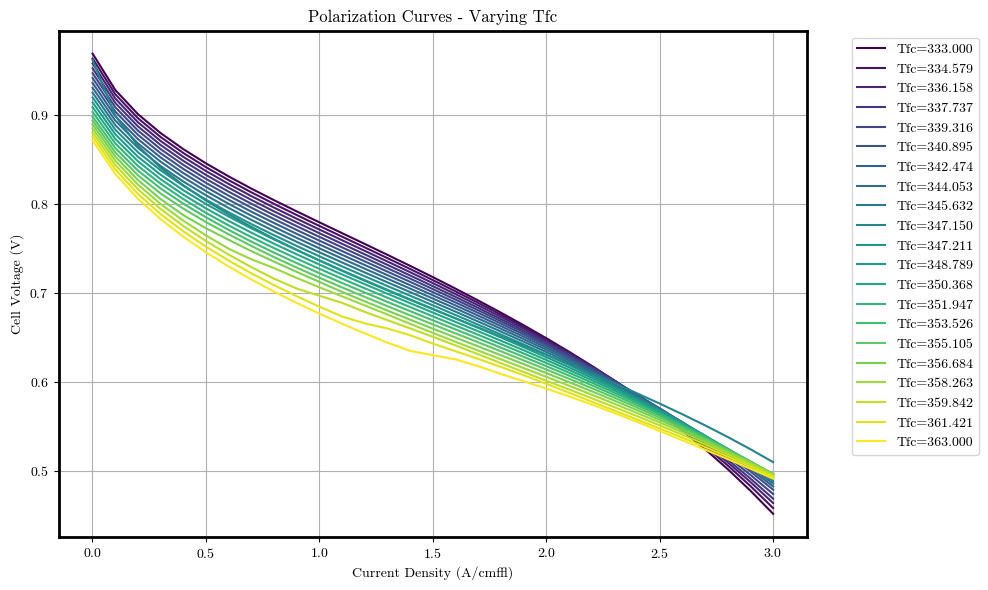


Analyzing parameter: Pa_des


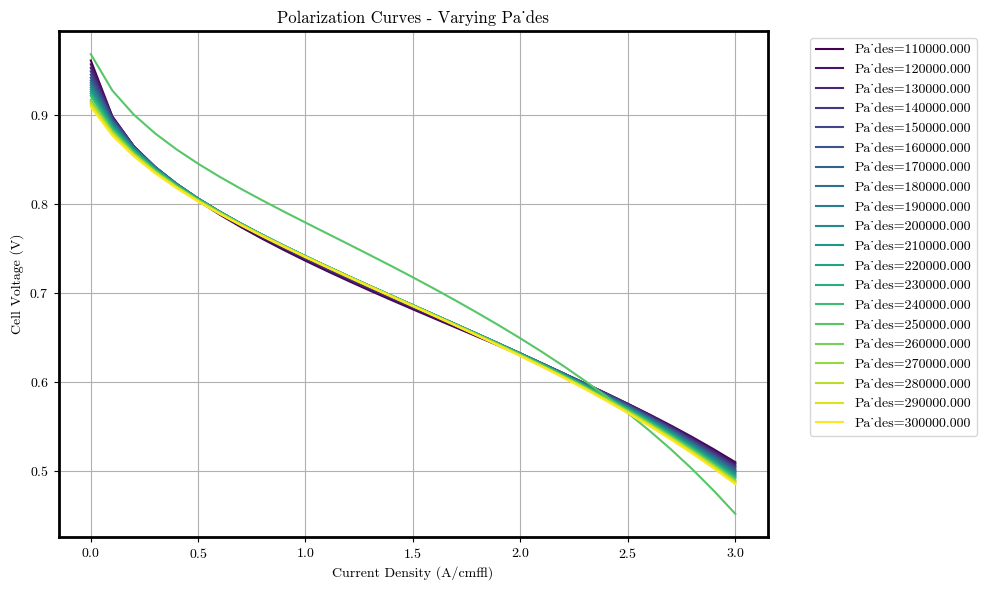


Analyzing parameter: Pc_des


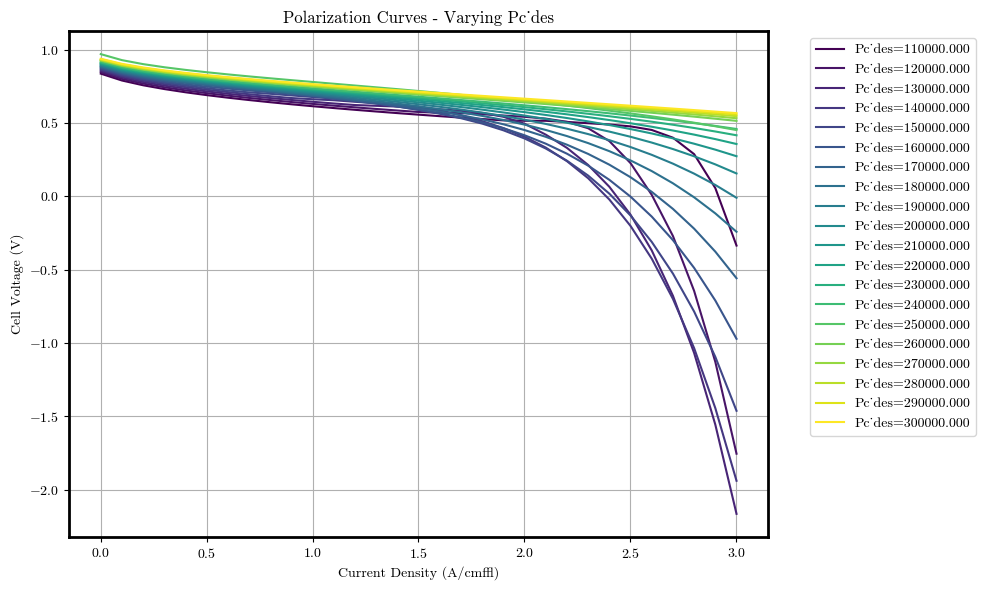


Analyzing parameter: Sc


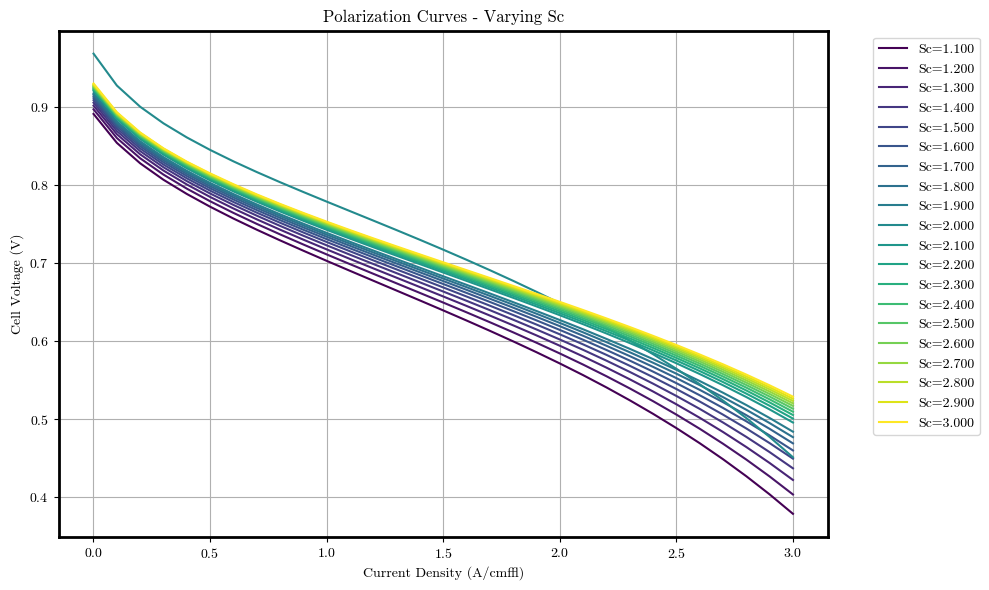


Analyzing parameter: Phi_c_des


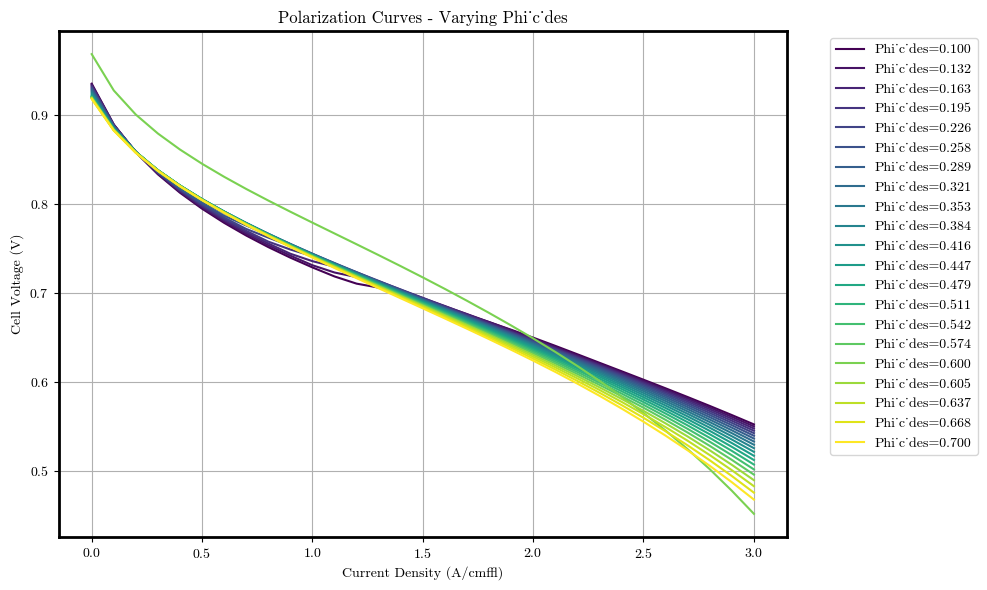


Analyzing parameter: epsilon_gdl


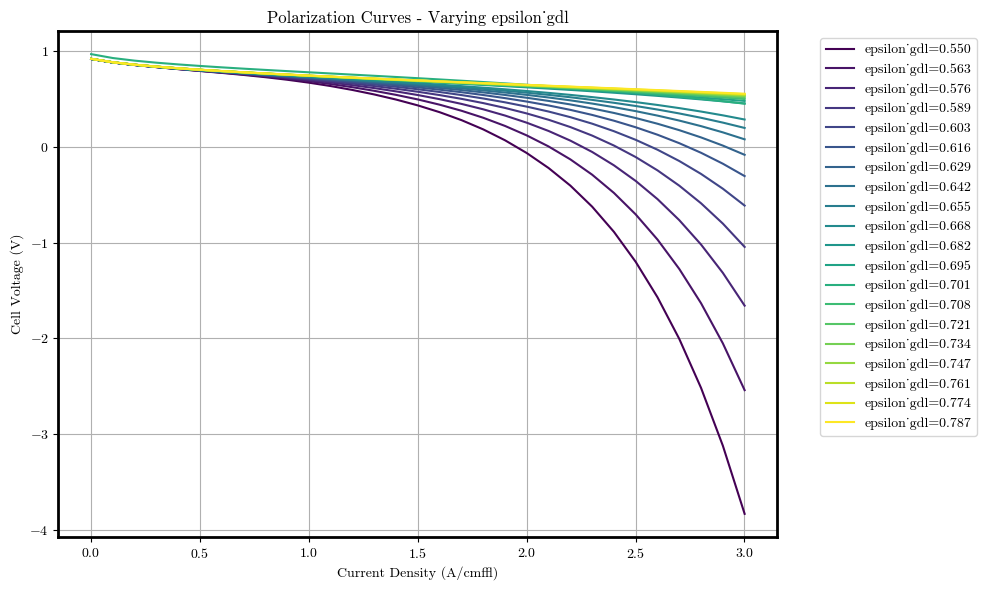


Analyzing parameter: tau


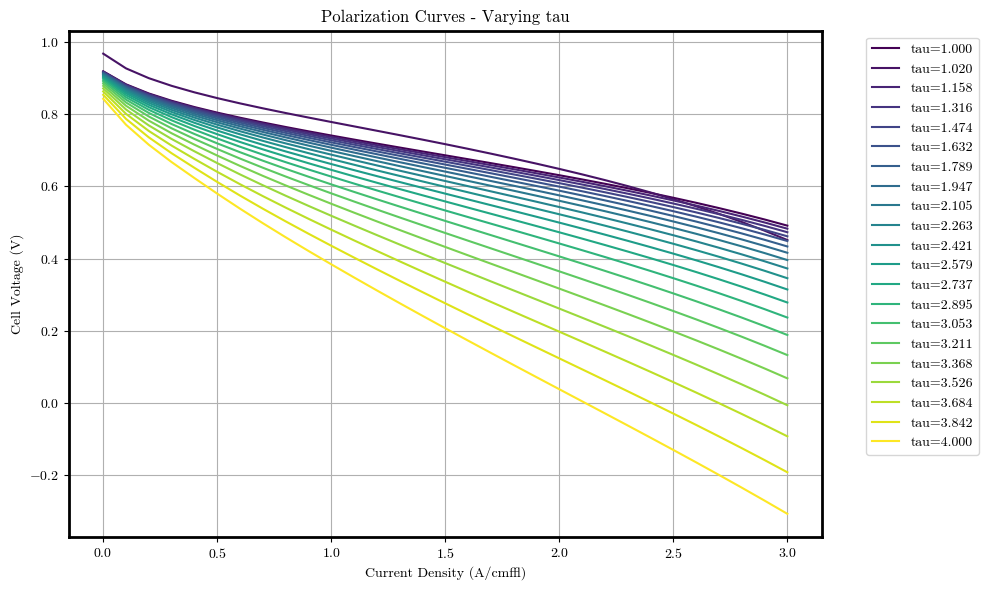


Analyzing parameter: epsilon_mc


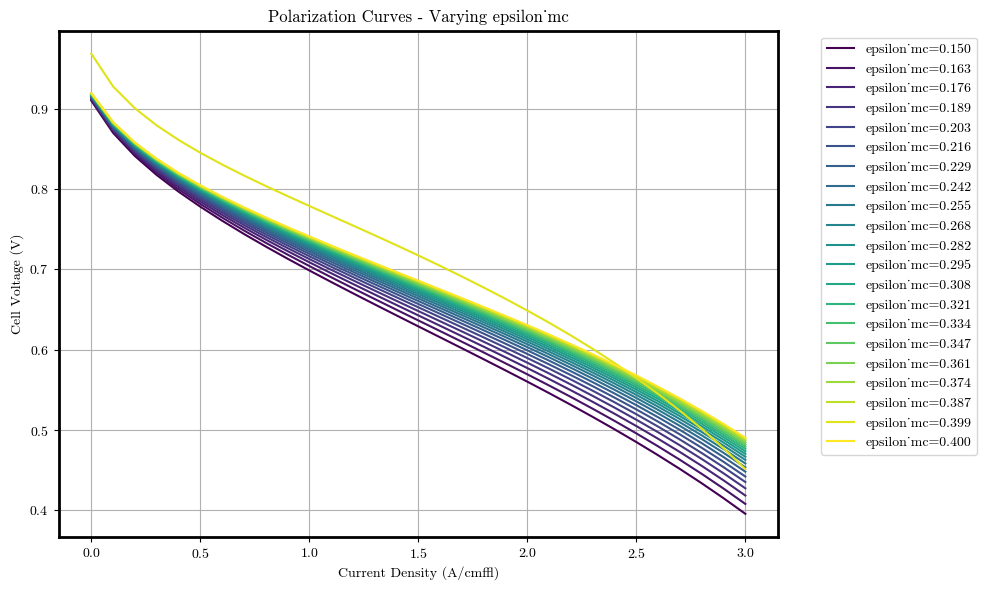


Analyzing parameter: epsilon_c


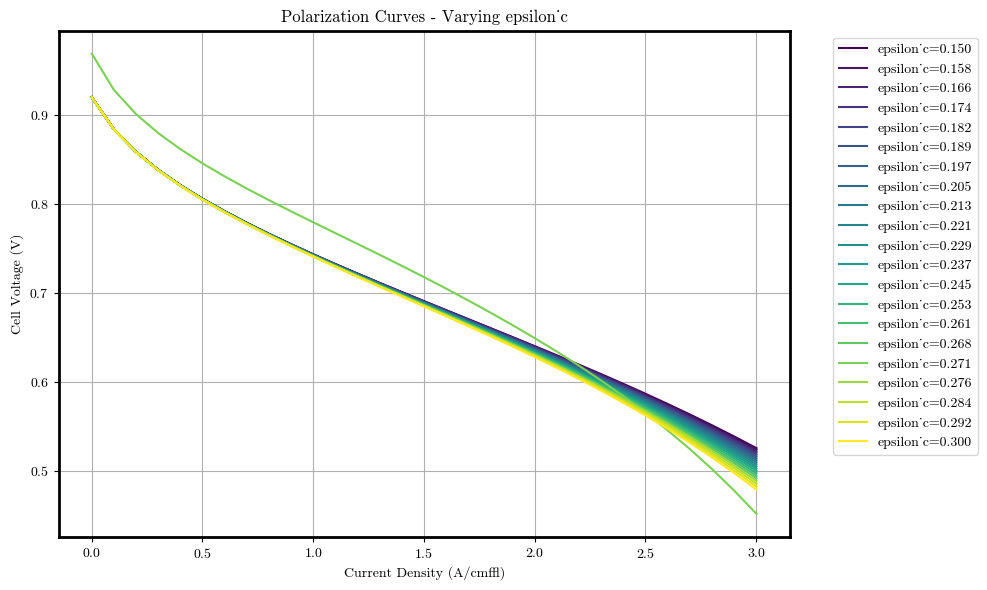


Analyzing parameter: e


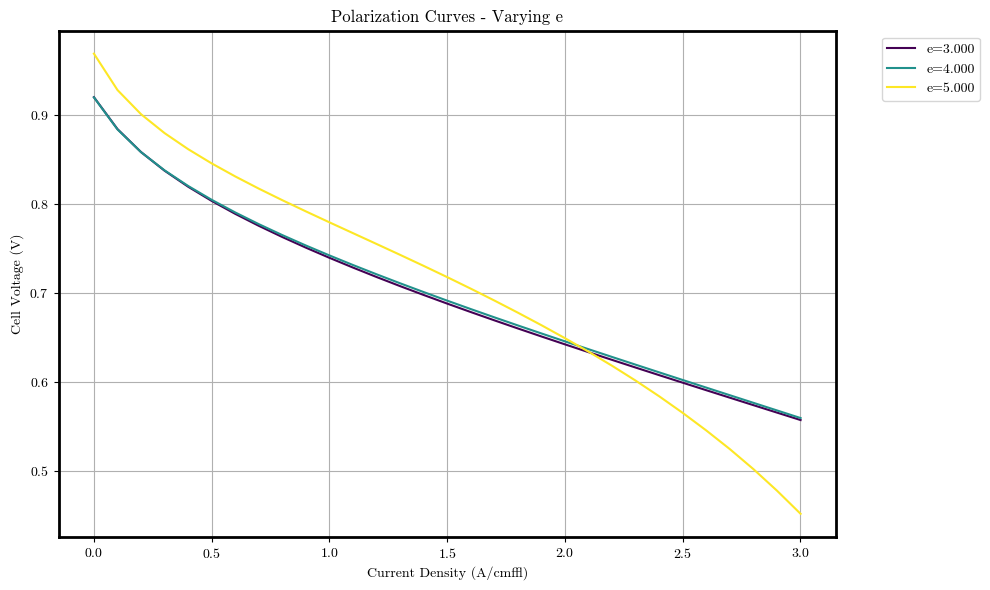


Analyzing parameter: Re


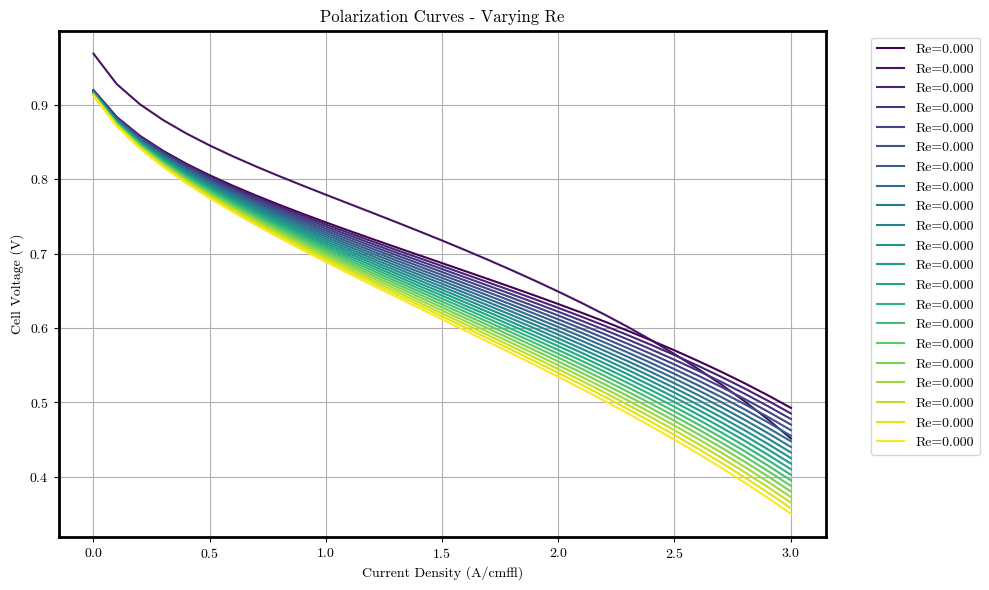


Analyzing parameter: i0_c_ref


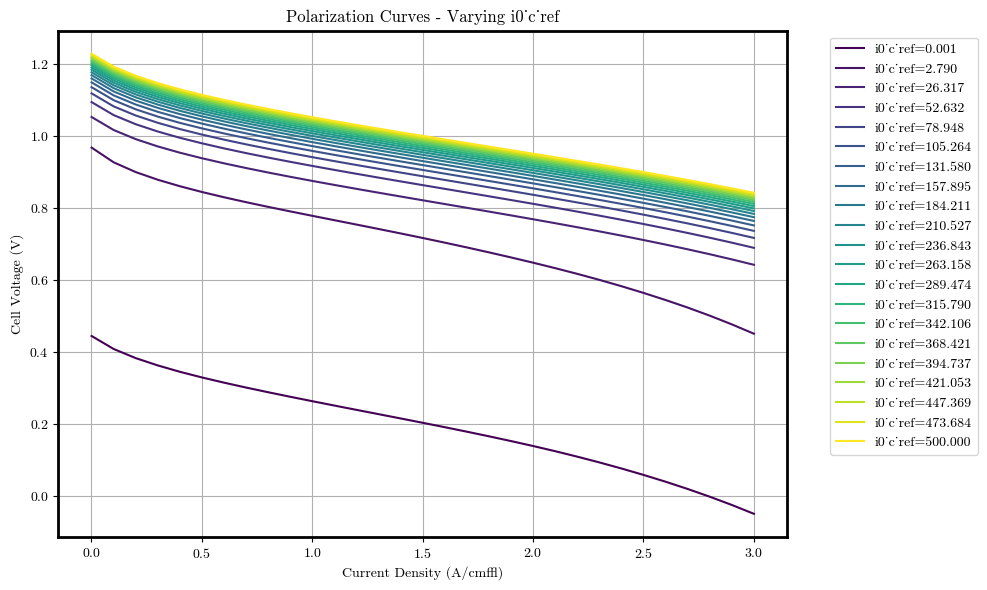


Analyzing parameter: kappa_co


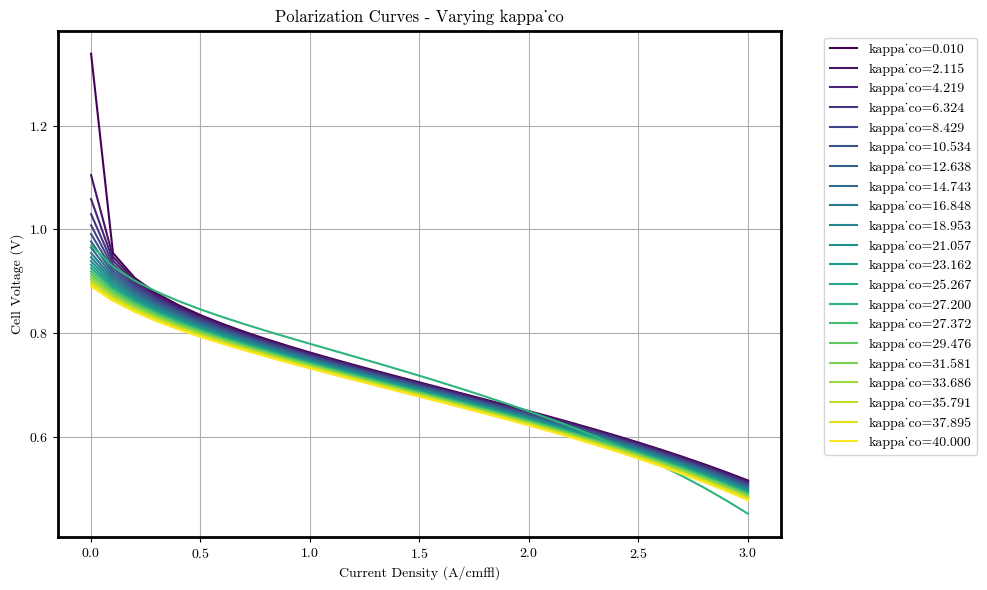


Analyzing parameter: kappa_c


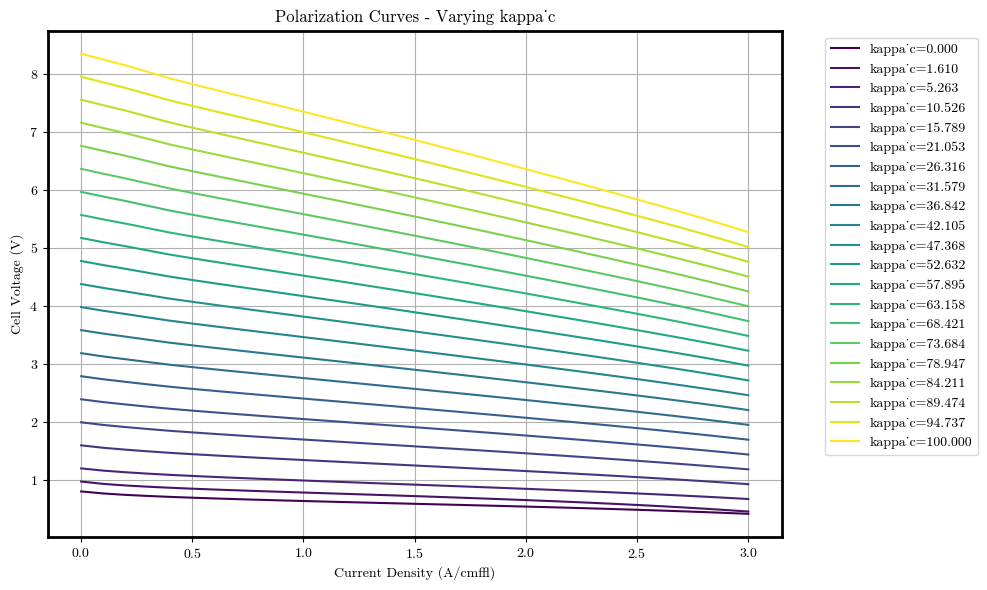


Analyzing parameter: a_slim


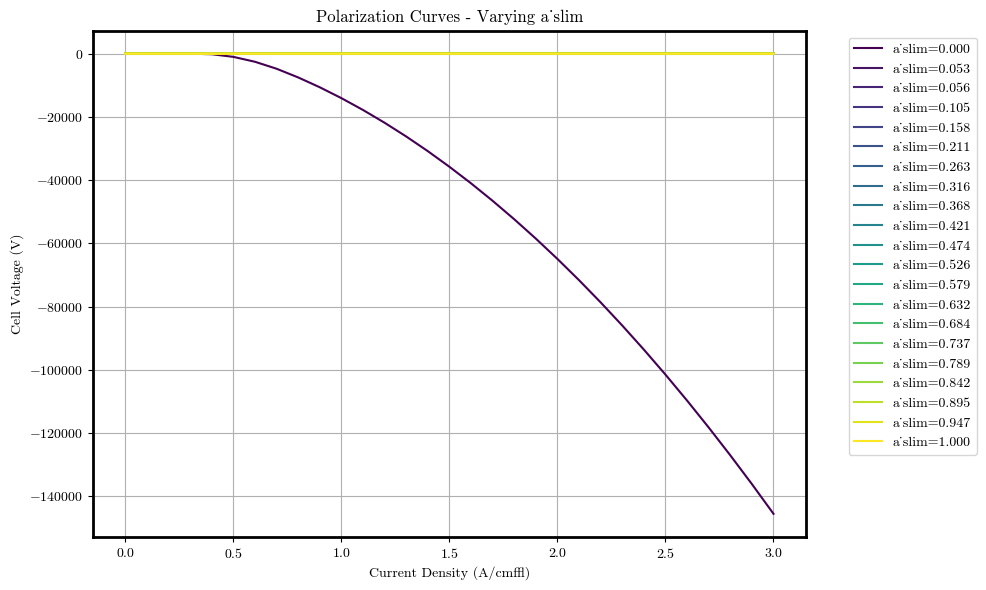


Analyzing parameter: b_slim


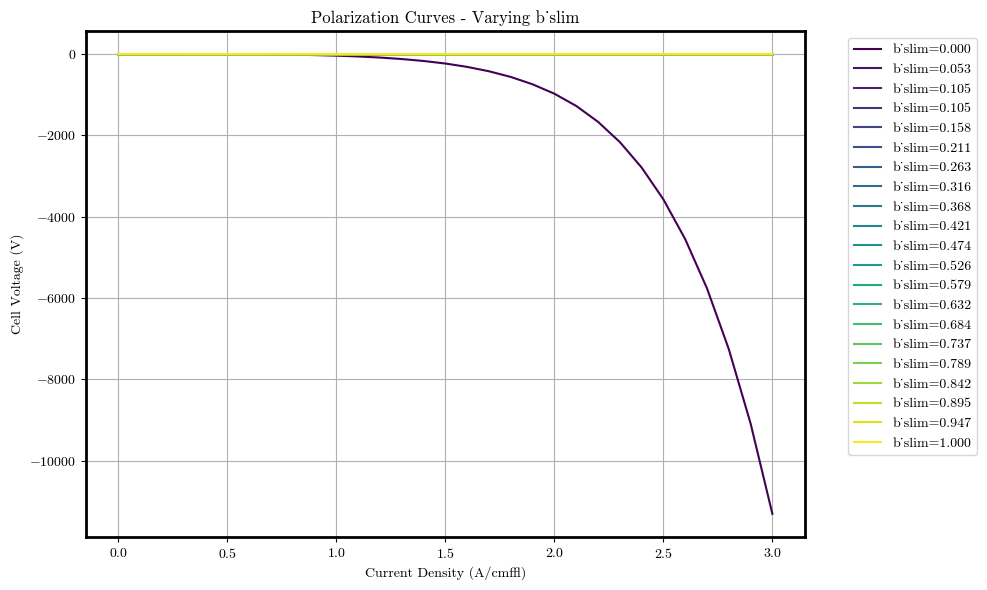


Analyzing parameter: a_switch


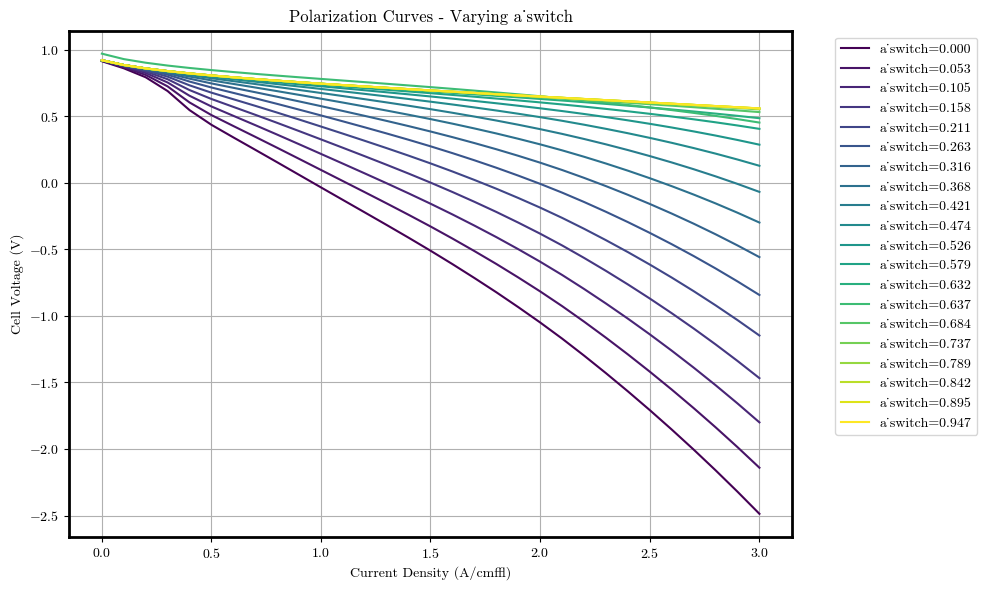

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_polarization_curves_for_param(data, param_name):
    """
    Plot polarization curves for different values of a single parameter using a color gradient
    
    Args:
        data (pd.DataFrame): DataFrame containing the simulation results
        param_name (str): Name of the parameter to analyze
    """
    plt.figure(figsize=(10, 6))
    
    # Get unique values for the parameter
    unique_values = sorted(data[param_name].unique())
    
    # Create color gradient
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_values)))
    
    # Plot a curve for each unique value
    for value, color in zip(unique_values, colors):
        subset = data[data[param_name] == value]
        ifc = subset['ifc'].iloc[0]  # Get first row's ifc list
        ucell = subset['Ucell'].iloc[0]  # Get first row's Ucell list
        
        plt.plot(ifc, ucell, label=f'{param_name}={value:.3f}', color=color)
    
    plt.xlabel('Current Density (A/cm²)')
    plt.ylabel('Cell Voltage (V)')
    plt.title(f'Polarization Curves - Varying {param_name}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Load the data
data = pd.read_pickle('../data/raw/PDP_20_default_updated.pkl')

# Plot polarization curves for each parameter in PARAMETER_RANGES
for param in PARAMETER_RANGES.keys():
    print(f"\nAnalyzing parameter: {param}")
    plot_polarization_curves_for_param(data, param)


Analyzing parameter: Tfc


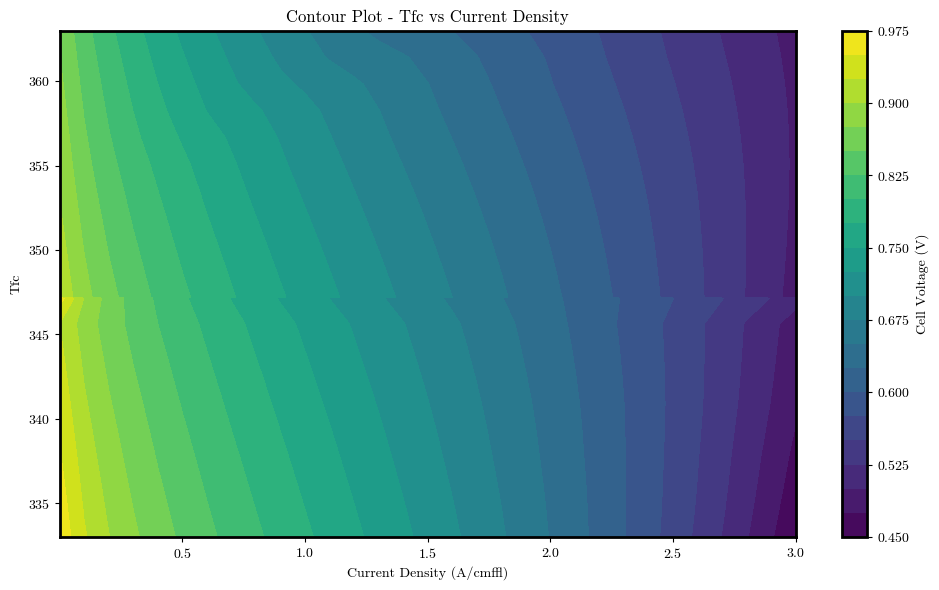


Analyzing parameter: Pa_des


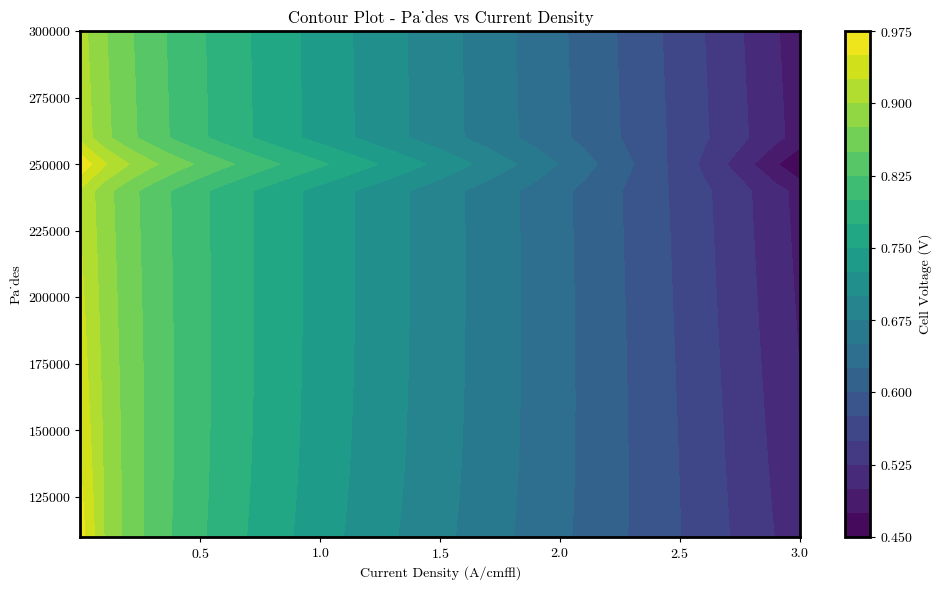


Analyzing parameter: Pc_des


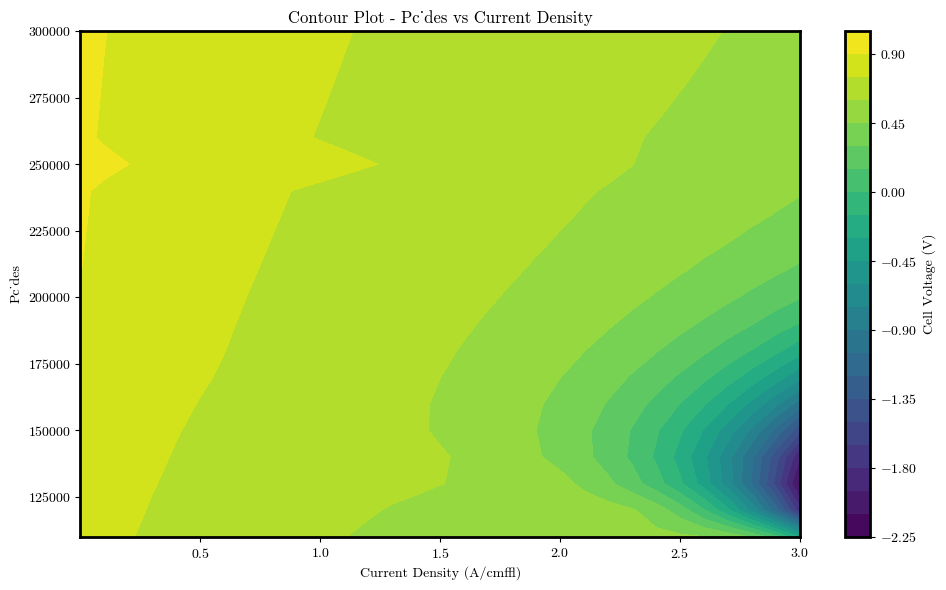


Analyzing parameter: epsilon_gdl


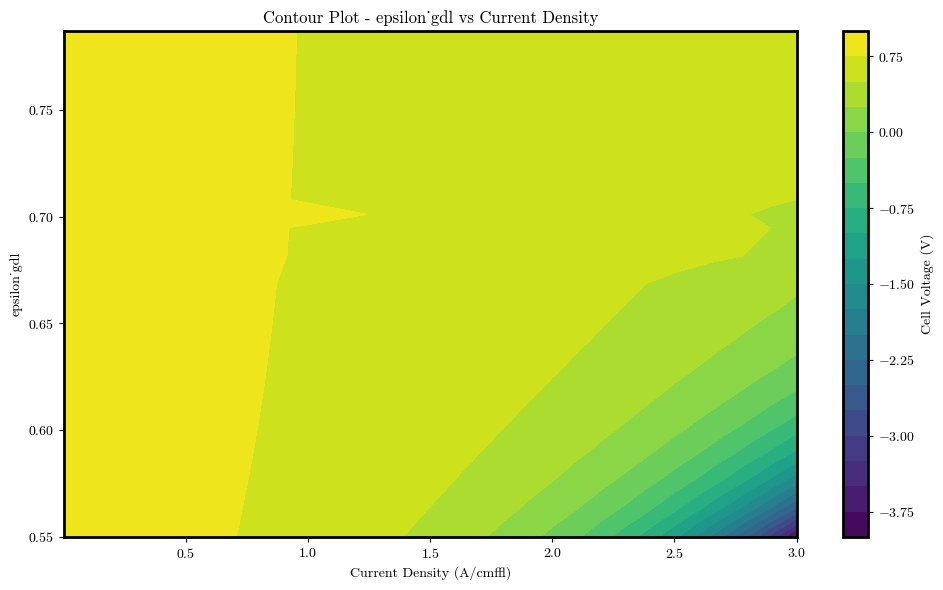


Analyzing parameter: tau


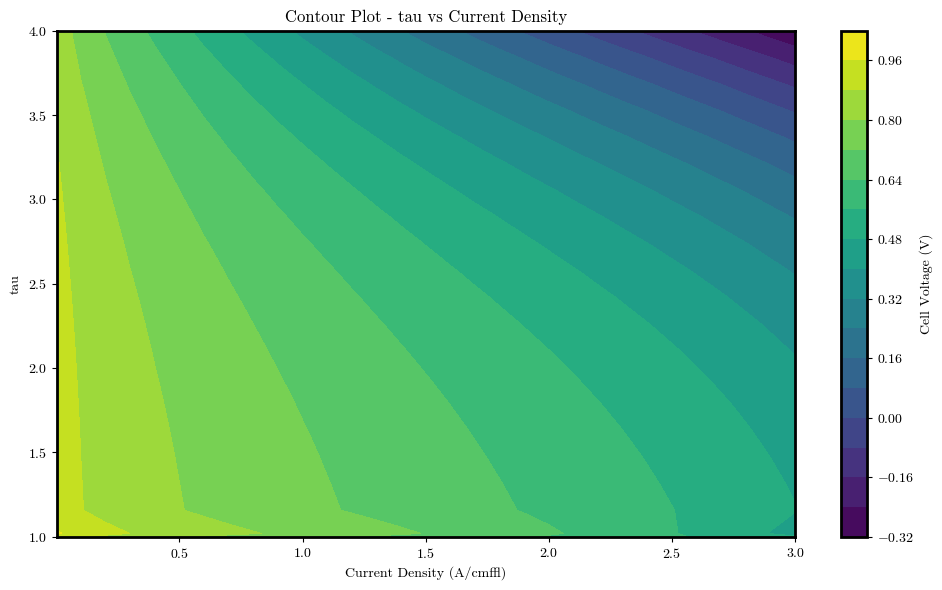

In [28]:
def plot_contour_for_param(data, param_name):
    """
    Create contour plot with current density on x-axis, parameter value on y-axis,
    and cell voltage as the contour color. Only for continuous parameters.
    
    Args:
        data (pd.DataFrame): DataFrame containing simulation results
        param_name (str): Name of parameter to analyze
    """
    plt.figure(figsize=(10, 6))
    
    # Get unique parameter values and first ifc array for x coordinates
    param_values = sorted(data[param_name].unique())
    
    # Skip if we have too few unique values (likely discrete parameter)
    if len(param_values) < 5:
        return
        
    ifc = data['ifc'].iloc[0]
    
    # Create meshgrid for contour plot
    X, Y = np.meshgrid(ifc, param_values)
    
    # Create Z matrix of Ucell values
    Z = np.zeros((len(param_values), len(ifc)))
    for i, value in enumerate(param_values):
        subset = data[data[param_name] == value]
        Z[i,:] = subset['Ucell'].iloc[0]
    
    # Create contour plot
    contour = plt.contourf(X, Y, Z, levels=20, cmap='viridis')
    plt.colorbar(contour, label='Cell Voltage (V)')
    
    plt.xlabel('Current Density (A/cm²)')
    plt.ylabel(param_name)
    plt.title(f'Contour Plot - {param_name} vs Current Density')
    plt.tight_layout()
    plt.show()

# Create contour plots for each continuous parameter
continuous_params = ['Tfc', 'Pa_des', 'Pc_des', 'epsilon_gdl', 'tau']
for param in continuous_params:
    print(f"\nAnalyzing parameter: {param}")
    plot_contour_for_param(data, param)

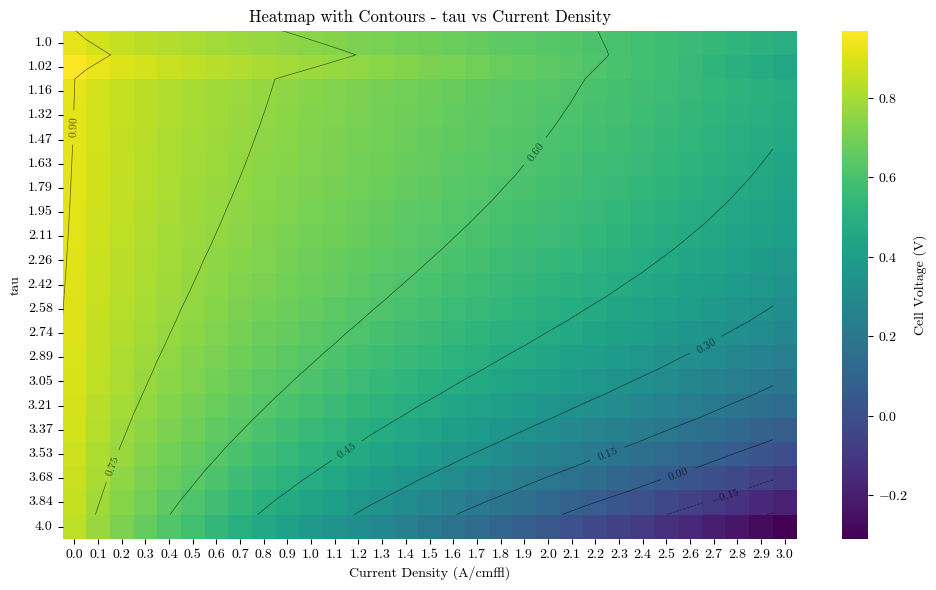

In [29]:
import seaborn as sns

def plot_heatmap_with_contours(data, param_name):
    param_values = sorted(data[param_name].unique())
    if len(param_values) < 5:
        return
    
    ifc = data['ifc'].iloc[0]
    Z = np.zeros((len(param_values), len(ifc)))
    
    for i, value in enumerate(param_values):
        subset = data[data[param_name] == value]
        Z[i,:] = subset['Ucell'].iloc[0]
    
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(Z, xticklabels=np.round(ifc, 2), yticklabels=np.round(param_values, 2), cmap="viridis", cbar_kws={'label': 'Cell Voltage (V)'})
    CS = plt.contour(Z, levels=10, colors='black', linewidths=0.5, alpha=0.6)
    plt.clabel(CS, inline=True, fontsize=8)
    
    plt.xlabel("Current Density (A/cm²)")
    plt.ylabel(param_name)
    plt.title(f"Heatmap with Contours - {param_name} vs Current Density")
    plt.tight_layout()
    plt.show()

plot_heatmap_with_contours(data, 'tau')

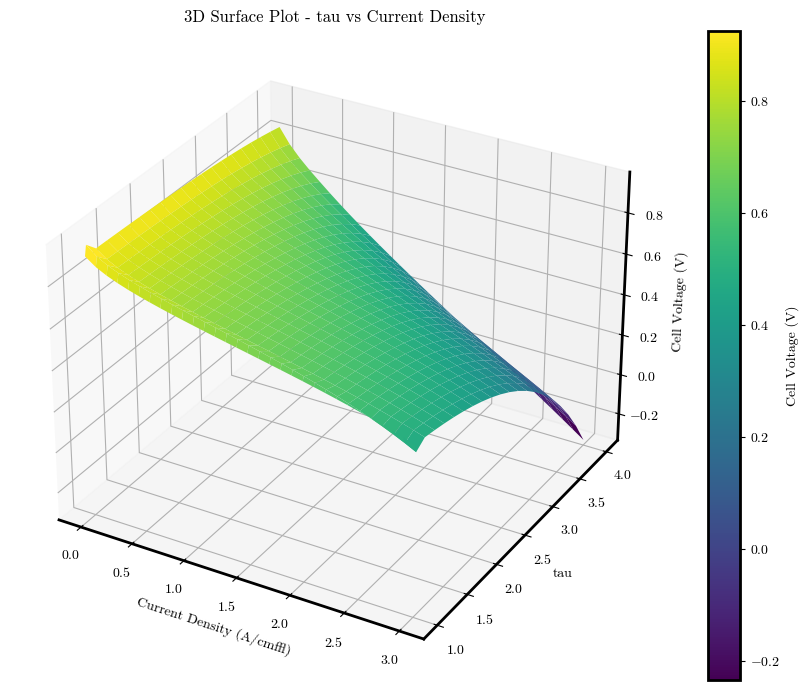

In [30]:
from mpl_toolkits.mplot3d import Axes3D

def plot_surface(data, param_name):
    param_values = sorted(data[param_name].unique())
    if len(param_values) < 5:
        return
    
    ifc = data['ifc'].iloc[0]
    Z = np.zeros((len(param_values), len(ifc)))
    for i, value in enumerate(param_values):
        subset = data[data[param_name] == value]
        Z[i,:] = subset['Ucell'].iloc[0]

    X, Y = np.meshgrid(ifc, param_values)
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    fig.colorbar(surf, ax=ax, label='Cell Voltage (V)')
    
    ax.set_xlabel('Current Density (A/cm²)')
    ax.set_ylabel(param_name)
    ax.set_zlabel('Cell Voltage (V)')
    ax.set_title(f'3D Surface Plot - {param_name} vs Current Density')
    plt.tight_layout()
    plt.show()

plot_surface(data, 'tau')

## **Validation full grid**

In [18]:
import itertools
data = pd.read_pickle('../data/raw/PDP_20_default_updated.pkl')

In [13]:
data.head()

Tfc    Pa_des    Pc_des   Sa   Sc  Phi_a_des  Phi_c_des  \
0  333.000000  250000.0  250000.0  1.2  2.0        0.4        0.6   
1  334.578947  250000.0  250000.0  1.2  2.0        0.4        0.6   
2  336.157895  250000.0  250000.0  1.2  2.0        0.4        0.6   
3  337.736842  250000.0  250000.0  1.2  2.0        0.4        0.6   
4  339.315789  250000.0  250000.0  1.2  2.0        0.4        0.6   

   epsilon_gdl   tau  epsilon_mc  ...  i_max_pola    Aact    Hgdl     Hmem  \
0        0.701  1.02       0.399  ...     30000.0  0.0085  0.0002  0.00002   
1        0.701  1.02       0.399  ...     30000.0  0.0085  0.0002  0.00002   
2        0.701  1.02       0.399  ...     30000.0  0.0085  0.0002  0.00002   
3        0.701  1.02       0.399  ...     30000.0  0.0085  0.0002  0.00002   
4        0.701  1.02       0.399  ...     30000.0  0.0085  0.0002  0.00002   

       Hcl     Hgc      Wgc   Lgc  \
0  0.00001  0.0005  0.00045  9.67   
1  0.00001  0.0005  0.00045  9.67   
2  0.00001  0.0005  0.00045  9.67   
3  0.00001  0.0005  0.00045  9.67   
4  0.00001  0.0005  0.00045  9.67   

                                                 ifc  \
0  [0.0008087911599308829, 0.10080741103267477, 0...   
1  [0.0008077512410977984, 0.10080636932256877, 0...   
2  [0.0008269306026891908, 0.10082558099616638, 0...   
3  [0.0008066798193319013, 0.10080529605043549, 0...   
4  [0.0008255807615178022, 0.10082422892999175, 0...   

                                               Ucell  
0  [0.9688710326571046, 0.9279798933162107, 0.900...  
1  [0.963406566155428, 0.9231973602856297, 0.8962...  
2  [0.9579147038480978, 0.9183588033119421, 0.891...  
3  [0.952437251648234, 0.9134874472761643, 0.8870...  
4  [0.9469288430461322, 0.9085562583046722, 0.882...  

[5 rows x 48 columns]

1. In this exercise we are going to compare the 20 values per feature that were plotted previously in order to determine whar were the combinations that didn't work.
Result: I couldn't replicate the grid with the values thatDejvis used :( with the code is above.

In [ ]:
columns_interes = list(PARAMETER_RANGES.keys()) # The features we are interested in
data_filt = data[columns_interes] # We filter the dataset of simulation results to keep only the columns of interest
unique_values = [data_filt[col].unique() for col in data_filt.columns] # For each feature we make a list of thier different values
qnt_uniq_val = [len(vari) for vari in unique_values] # we count how many different values each column has
qnt_ori = [len(values) for key,values in param_grids.items()] # we count how many different values each column has in the original parameter grid

diff_indices = [i for i, (a, b) in enumerate(zip(qnt_uniq_val, qnt_ori)) if a == b] # Find indices where qnt_uniq_val and qnt_ori differ
diff_values = [set(param_grids[columns_interes[i]]) - set(unique_values[i]) for i in diff_indices] # we determine the values that are not present in the simulation results for each column where the number of unique values differs

2. In this part we take a closer look to the plots of `a_slim` and `b_slim` due to the fact that in the previous plot was not easy to see the behavior of most of the curves because there was an outlier.

The function `plot_polarization_curves_for_param` takes a parameter of interest and filter just above or below a percentile with the aim to take out the outliers 

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_polarization_curves_for_param(data, param_name, percentile_type='lower',per=10):
    """
    Plot polarization curves for the lowest or highest 90% of parameter values using a color gradient.
    
    Args:
        data (pd.DataFrame): DataFrame containing the simulation results.
        param_name (str): Name of the parameter to analyze.
        percentile_type (str): Either 'lower' or 'upper' to indicate which 90% to plot.
    """
    plt.figure(figsize=(10, 6))
    
    # Get sorted unique values for the parameter and convert to NumPy array
    unique_values = np.sort(data[param_name].unique())
    
    # Compute percentiles
    lower_cutoff = np.percentile(unique_values, per)
    upper_cutoff = np.percentile(unique_values, 100-per)

    # Filter based on the selected percentile type
    if percentile_type == 'lower':
        selected_values = unique_values[unique_values <= upper_cutoff]
        title_prefix = "Lower 90%"
    elif percentile_type == 'upper':
        selected_values = unique_values[unique_values >= lower_cutoff]
        title_prefix = "Upper 90%"
    else:
        raise ValueError("percentile_type must be 'lower' or 'upper'")

    # Create color gradient
    colors = plt.cm.viridis(np.linspace(0, 1, len(selected_values)))
    
    # Plot a curve for each selected value
    for value, color in zip(selected_values, colors):
        subset = data[data[param_name] == value]
        if len(subset) == 0:
            continue  # Skip if no matching data
        ifc = subset['ifc'].iloc[0]
        ucell = subset['Ucell'].iloc[0]
        
        plt.plot(ifc, ucell, label=f'{param_name}={value:.3f}', color=color)
    
    plt.xlabel('Current Density (A/cm²)')
    plt.ylabel('Cell Voltage (V)')
    plt.title(f'{title_prefix} Polarization Curves - {param_name}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


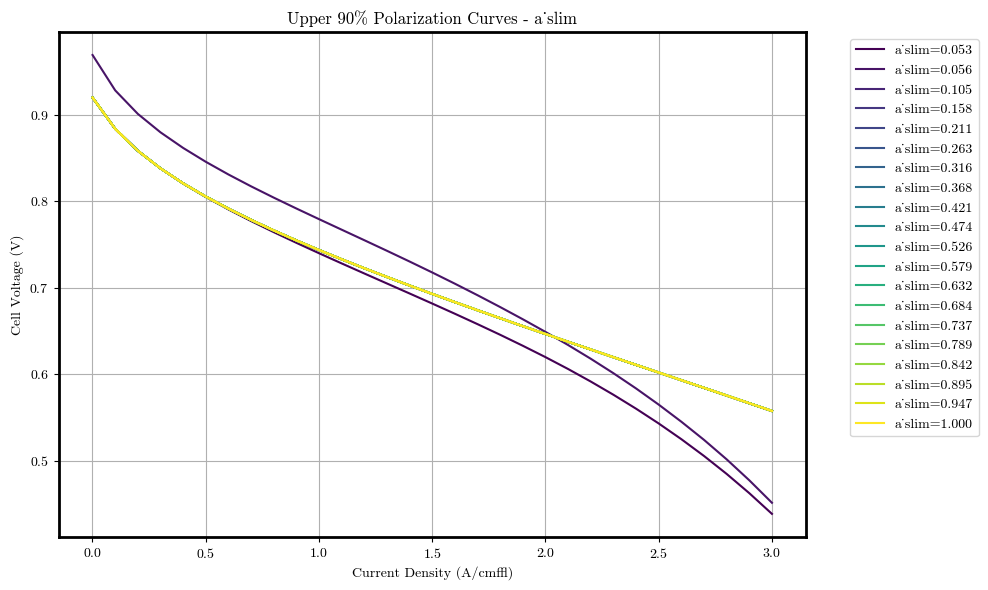

In [58]:
plot_polarization_curves_for_param(data, 'a_slim', percentile_type='upper',per=1)

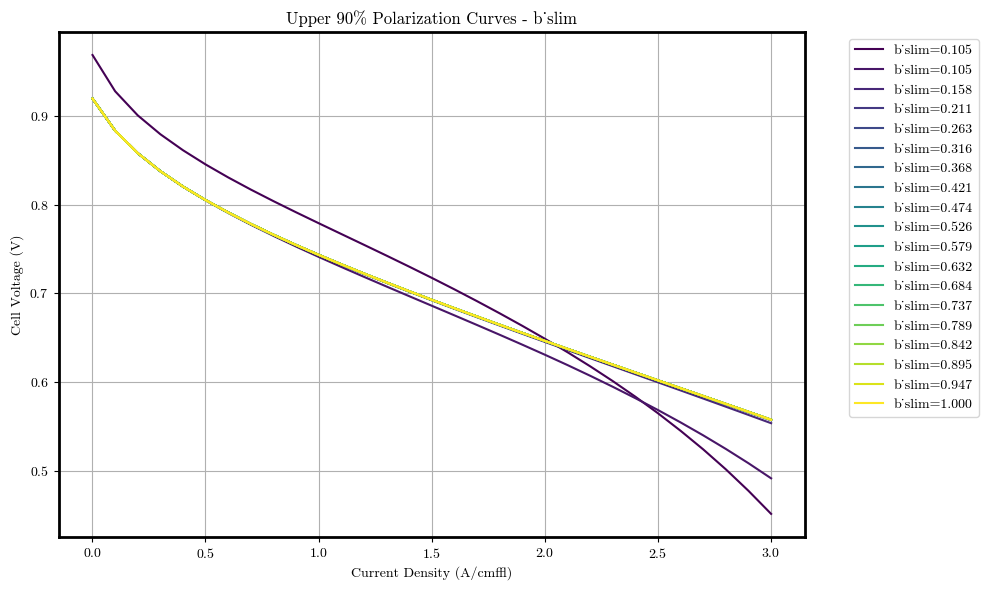

In [61]:
plot_polarization_curves_for_param(data, 'b_slim', percentile_type='upper',per=10)

3.  In this exercise we try 64 different combinations to optain the polarizations curves in order to evaluate the ranges of different features were it would be possible to samplpe from in order to avoid unsuitable configurations.
In this case we just took values after looking the previous plot and choosing values around the default one that seem to be a reasonable interval to sample from. In this case we just took 2 different values of 6 of the features of interest, the rest of the parameters keept with the default value.

In [64]:
##all possible combinations
values_try = default_values = {'Tfc':[347.15],#[342.474,353.526],
 'Pa_des': [2.e5],#[1.7e5,2.4e5],
 'Pc_des': [2e5,2.8e5],
 'Sa': [1.2],
 'Sc': [2],#[1.7,2.6],
 'Phi_a_des': [0.4],
 'Phi_c_des': [0.6],#[0.66,0.44],
 'epsilon_gdl': [0.701], # could be problematic
 'tau': [1.316,1.789],
 'epsilon_mc': [0.399],#[0.334,0.295],
 'epsilon_c': [0.245,0.292],
 'e': [5],
 'Re': [5.7e-7],
 'i0_c_ref': [2.79],
 'kappa_co': [27.2],#[21.057,31.581],
 'kappa_c': [1.61],
 'a_slim': [0.211,0.3668],
 'b_slim': [0.368,0.842],
 'a_switch': [0.526,0.842]}

In [66]:
# Extract keys and all value combinations
keys = list(values_try.keys())
value_combinations = list(itertools.product(*values_try.values()))

# Create DataFrame
df_combinations = pd.DataFrame(value_combinations, columns=keys)

In [68]:
df_combinations.shape

(64, 19)

In [71]:
saved_data_file = True
save_filepath = "../data/raw/try_combinations_after_rev_conf.pkl"
df_pol_cu = get_polarisation_curve_samples(sampled_parameters=df_combinations.to_dict(orient='records'), fixed_parameters=build_fixed_parameters(), save_path=save_filepath, save_every=10)


✅ Saved 10 samples to ../data/raw/try_combinations_after_rev_conf.pkl
✅ Saved 20 samples to ../data/raw/try_combinations_after_rev_conf.pkl
✅ Saved 30 samples to ../data/raw/try_combinations_after_rev_conf.pkl
✅ Saved 40 samples to ../data/raw/try_combinations_after_rev_conf.pkl
✅ Saved 50 samples to ../data/raw/try_combinations_after_rev_conf.pkl
✅ Saved 60 samples to ../data/raw/try_combinations_after_rev_conf.pkl

📁 Final save complete: ../data/raw/try_combinations_after_rev_conf.pkl with 64 valid samples.


In [ ]:
data_rev = pd.read_pickle('../data/raw/try_combinations_after_rev_conf.pkl')
data_filt2 = data_rev[columns_interes]
unique_values = [data_filt2[col].unique() for col in data_filt2.columns]
qnt_uniq_val = [len(vari) for vari in unique_values]

In [74]:
data_rev.head()

Tfc    Pa_des    Pc_des   Sa  Sc  Phi_a_des  Phi_c_des  epsilon_gdl  \
0  347.15  200000.0  200000.0  1.2   2        0.4        0.6        0.701   
1  347.15  200000.0  200000.0  1.2   2        0.4        0.6        0.701   
2  347.15  200000.0  200000.0  1.2   2        0.4        0.6        0.701   
3  347.15  200000.0  200000.0  1.2   2        0.4        0.6        0.701   
4  347.15  200000.0  200000.0  1.2   2        0.4        0.6        0.701   

     tau  epsilon_mc  ...  i_max_pola    Aact    Hgdl     Hmem      Hcl  \
0  1.316       0.399  ...     30000.0  0.0085  0.0002  0.00002  0.00001   
1  1.316       0.399  ...     30000.0  0.0085  0.0002  0.00002  0.00001   
2  1.316       0.399  ...     30000.0  0.0085  0.0002  0.00002  0.00001   
3  1.316       0.399  ...     30000.0  0.0085  0.0002  0.00002  0.00001   
4  1.316       0.399  ...     30000.0  0.0085  0.0002  0.00002  0.00001   

      Hgc      Wgc   Lgc                                                ifc  \
0  0.0005  0.00045  9.67  [0.0008195712066925043, 0.1008182093804012, 0....   
1  0.0005  0.00045  9.67  [0.0008195712023842507, 0.10081820937608574, 0...   
2  0.0005  0.00045  9.67  [0.0008195712066925043, 0.1008182093804012, 0....   
3  0.0005  0.00045  9.67  [0.0008195712023842507, 0.10081820937608574, 0...   
4  0.0005  0.00045  9.67  [0.0008195712066925043, 0.1008182093804012, 0....   

                                               Ucell  
0  [0.9083029143491063, 0.8628951269537378, 0.833...  
1  [0.9083030152254911, 0.8628960735310629, 0.833...  
2  [0.9083029143491063, 0.8628952066075447, 0.833...  
3  [0.9083030152254911, 0.8628960735310629, 0.833...  
4  [0.9083029143491063, 0.8628951876622022, 0.833...  

[5 rows x 48 columns]

In [178]:
def plot_all_curves(data_rev, ax=None):
    """
    Plot all polarization curves from the DataFrame on the given Axes object.
    If no Axes is provided, a new figure and Axes are created.
    """
    import matplotlib.pyplot as plt

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        show_plot = True
    else:
        show_plot = False

    # Iterate through each row in the DataFrame
    for index, row in data_rev.iterrows():
        ifc = row['ifc']
        ucell = row['Ucell']
        ax.plot(ifc, ucell, label=f'Curve {index}')
    
    ax.set_xlabel('Current Density (A/cm²)')
    ax.set_ylabel('Cell Voltage (V)')
    ax.set_title('All Polarization Curves')
    ax.grid(True)

    # Optional: show legend if desired
    # ax.legend(loc='best')

    if show_plot:
        plt.tight_layout()
        plt.show()


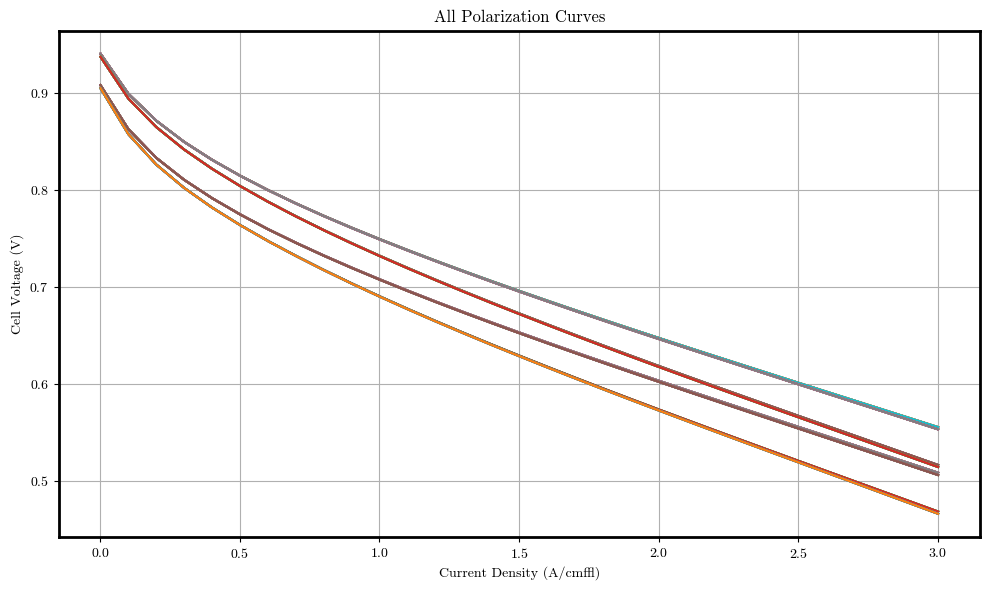

In [103]:
plot_all_curves(data_rev)

4. After observing that none of the combinations previously plotted had problems, we decided to run a sample of 400 combinations using the values in between from the intervals prevously evaluated.

In [90]:
##all possible combinations
values_try = {'Tfc':[347.15],#[342.474,353.526],
 'Pa_des': [2.e5],#[1.7e5,2.4e5],
 'Pc_des': [2e5,2.8e5],
 'Sa': [1.2],
 'Sc': [2],#[1.7,2.6],
 'Phi_a_des': [0.4],
 'Phi_c_des': [0.6],#[0.66,0.44],
 'epsilon_gdl': [0.701], # could be problematic
 'tau': [1.316,1.789],
 'epsilon_mc': [0.399],#[0.334,0.295],
 'epsilon_c': [0.245,0.292],
 'e': [5],
 'Re': [5.7e-7],
 'i0_c_ref': [2.79],
 'kappa_co': [27.2],#[21.057,31.581],
 'kappa_c': [1.61],
 'a_slim': [0.211,0.3668],
 'b_slim': [0.368,0.842],
 'a_switch': [0.526,0.842]}

In [ ]:
# In this case we take the intervals we prevously defined in values_try and filter from the original grid defined for the plots to take possible intermediate values.
filtered_values = {}
for key, val_list in values_try.items():
    if len(val_list) > 1:
        vmin, vmax = min(val_list), max(val_list)
        # Filter values in data_filt[key] that are between vmin and vmax (inclusive)
        filtered = sorted([v for v in data_filt[key].unique() if vmin <= v <= vmax])
        filtered_values[key] = filtered
    else:
        filtered_values[key] = val_list

In [ ]:
# Extract keys and all value combinations
keys = list(filtered_values.keys())
value_combinations = list(itertools.product(*filtered_values.values()))

# Create DataFrame
df_combinations2 = pd.DataFrame(value_combinations, columns=keys)
df_combinations2_sampled = df_combinations2.sample(n=400, random_state=42) # As all possible combinations are too many, we sample 400 of them to make the analysis more manageable.

In [99]:
df_combinations2_sampled.to_pickle("../data/raw/try_combinations_after_rev_conf2_or_samples.pkl")

In [ ]:
saved_data_file = True
save_filepath = "../data/raw/try_combinations_after_rev_conf2.pkl"
df_pol_cu = get_polarisation_curve_samples(sampled_parameters=df_combinations2_sampled.to_dict(orient='records'), fixed_parameters=build_fixed_parameters(), save_path=save_filepath, save_every=10)


✅ Saved 10 samples to ../data/raw/try_combinations_after_rev_conf2.pkl
✅ Saved 20 samples to ../data/raw/try_combinations_after_rev_conf2.pkl
✅ Saved 30 samples to ../data/raw/try_combinations_after_rev_conf2.pkl
✅ Saved 40 samples to ../data/raw/try_combinations_after_rev_conf2.pkl
✅ Saved 50 samples to ../data/raw/try_combinations_after_rev_conf2.pkl
✅ Saved 60 samples to ../data/raw/try_combinations_after_rev_conf2.pkl
✅ Saved 70 samples to ../data/raw/try_combinations_after_rev_conf2.pkl
✅ Saved 80 samples to ../data/raw/try_combinations_after_rev_conf2.pkl
✅ Saved 90 samples to ../data/raw/try_combinations_after_rev_conf2.pkl
✅ Saved 100 samples to ../data/raw/try_combinations_after_rev_conf2.pkl
✅ Saved 110 samples to ../data/raw/try_combinations_after_rev_conf2.pkl
✅ Saved 120 samples to ../data/raw/try_combinations_after_rev_conf2.pkl
✅ Saved 130 samples to ../data/raw/try_combinations_after_rev_conf2.pkl
✅ Saved 140 samples to ../data/raw/try_combinations_after_rev_conf2.pkl
✅

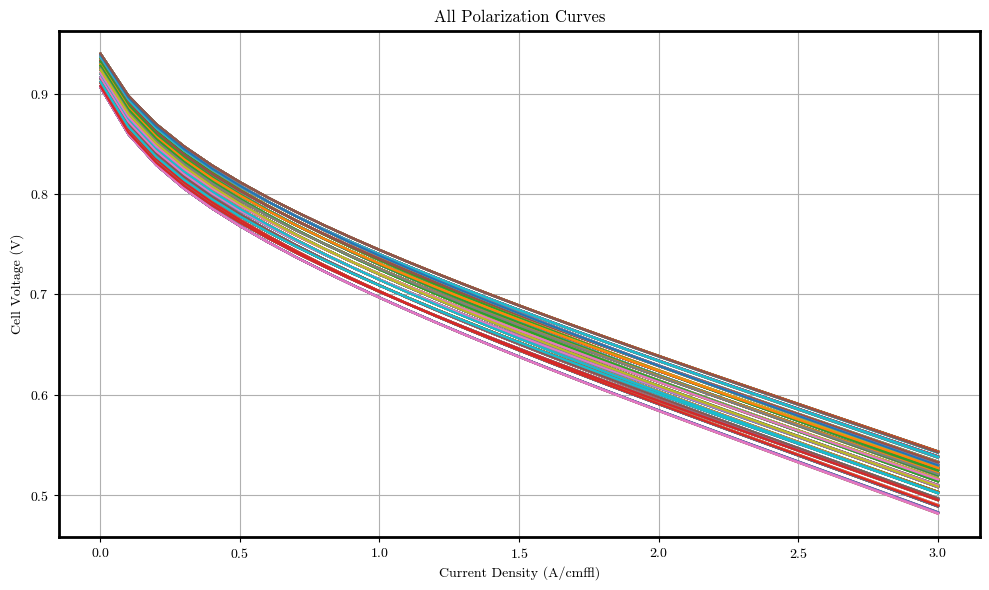

In [104]:
data_rev2 = pd.read_pickle('../data/raw/try_combinations_after_rev_conf2.pkl')
plot_all_curves(data_rev2)

5. After we visually didn't detect any isue in the configurations. We decided to modify the values for 12 features. As there were too many possible combinations,we just took a sample of other 400 configurations.

In [ ]:
##all possible combinations
values_try = default_values = {'Tfc':[342.474,353.526],
 'Pa_des': [1.7e5,2.4e5],
 'Pc_des': [2e5,2.8e5],
 'Sa': [1.2],
 'Sc': [1.7,2.6], 
 'Phi_a_des': [0.4],
 'Phi_c_des': [0.66,0.44],
 'epsilon_gdl': [0.701], # could be problematic
 'tau': [1.316,1.789],
 'epsilon_mc': [0.334,0.295],
 'epsilon_c': [0.245,0.292],
 'e': [5],
 'Re': [5.7e-7],
 'i0_c_ref': [2.79],
 'kappa_co': [21.057,31.581],
 'kappa_c': [1.61],
 'a_slim': [0.211,0.3668],
 'b_slim': [0.368,0.842],
 'a_switch': [0.526,0.842]}

# Extract keys and all value combinations
keys = list(values_try.keys())
value_combinations = list(itertools.product(*values_try.values()))

# Create DataFrame
df_combinations3 = pd.DataFrame(value_combinations, columns=keys)
df_combinations3_sampled = df_combinations3.sample(n=400, random_state=42)

In [106]:
df_combinations3_sampled.to_pickle("../data/raw/try_combinations_after_rev_conf3_or_samples.pkl")

In [107]:
saved_data_file = True
save_filepath = "../data/raw/try_combinations_after_rev_conf3.pkl"
df_pol_cu = get_polarisation_curve_samples(sampled_parameters=df_combinations3_sampled.to_dict(orient='records'), fixed_parameters=build_fixed_parameters(), save_path=save_filepath, save_every=10)

✅ Saved 10 samples to ../data/raw/try_combinations_after_rev_conf3.pkl
✅ Saved 20 samples to ../data/raw/try_combinations_after_rev_conf3.pkl
✅ Saved 30 samples to ../data/raw/try_combinations_after_rev_conf3.pkl
✅ Saved 40 samples to ../data/raw/try_combinations_after_rev_conf3.pkl
✅ Saved 50 samples to ../data/raw/try_combinations_after_rev_conf3.pkl
✅ Saved 60 samples to ../data/raw/try_combinations_after_rev_conf3.pkl
✅ Saved 70 samples to ../data/raw/try_combinations_after_rev_conf3.pkl
✅ Saved 80 samples to ../data/raw/try_combinations_after_rev_conf3.pkl
✅ Saved 90 samples to ../data/raw/try_combinations_after_rev_conf3.pkl
✅ Saved 100 samples to ../data/raw/try_combinations_after_rev_conf3.pkl
✅ Saved 110 samples to ../data/raw/try_combinations_after_rev_conf3.pkl
✅ Saved 120 samples to ../data/raw/try_combinations_after_rev_conf3.pkl
✅ Saved 130 samples to ../data/raw/try_combinations_after_rev_conf3.pkl
✅ Saved 140 samples to ../data/raw/try_combinations_after_rev_conf3.pkl
✅

In this case we plotted the curve and noticed that some of them have a particular behaviour (increasing patern) that requiered a closer look

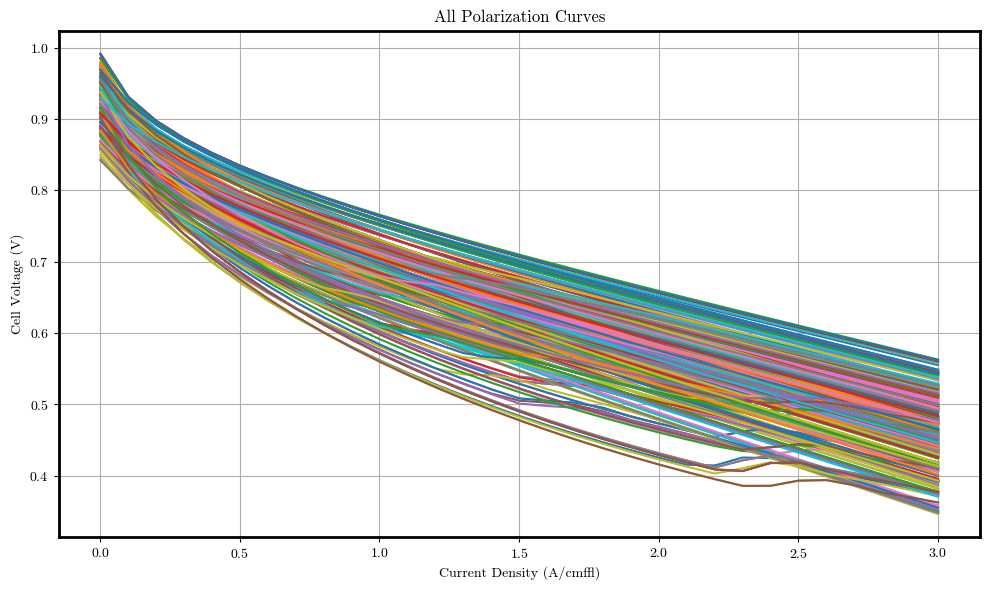

In [108]:
data_rev3 = pd.read_pickle('../data/raw/try_combinations_after_rev_conf3.pkl')
plot_all_curves(data_rev3)

In [ ]:
# We see the output of the polarization curves ans filter them that have a growth in the cell voltage.
df_ucells = pd.DataFrame(data_rev3['Ucell'].tolist())
df_ucells.shape
df_ucells_diff = df_ucells.diff(axis=1) # We take the difference of the voltage with the prevoius one to see if there is a growth in the cell voltage.
df_ucells_filtered = df_ucells_diff[df_ucells_diff.gt(0).any(axis=1)] # We filter the curves that had any possitive value in those differences.
df_ucells_filtered.shape

(400, 31)

In [ ]:
df_ucells_filtered.index # The indexes of the curves that grew at any point.

Index([  6,   9,  16,  18,  20,  36,  48,  52,  54,  88, 136, 146, 150, 163,
       206, 219, 237, 242, 308, 312, 315, 338, 352, 353, 355, 365, 377, 385,
       394, 395],
      dtype='int64')

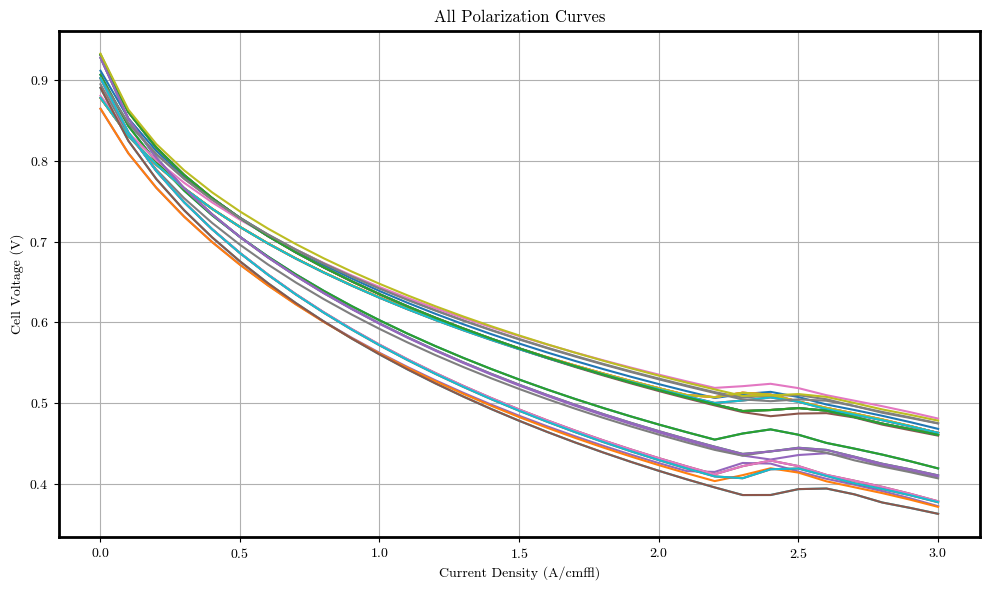

In [ ]:
data_rev3_filt_grow = data_rev3.iloc[df_ucells_filtered.index]
plot_all_curves(data_rev3_filt_grow)

In [ ]:
independent_params = [k for k, v in PARAMETER_RANGES.items()]
data_rev3_filt_grow = data_rev3_filt_grow[independent_params ]
data_rev3_filt_grow_cmpl = pd.concat([data_rev3_filt_grow, df_ucells_filtered,df_ucells.iloc[df_ucells_filtered.index]], axis=1)
data_rev3_filt_grow_cmpl.to_csv("../data/raw/configuration_check_grow_230525.csv", index=False)

In [ ]:
# We filtered the curves were the Pa_des is larger that Pc_des, due to is a restriction of the configuration.
data_rev3_filt_grow_rev = data_rev3_filt_grow[data_rev3_filt_grow['Pa_des']>=data_rev3_filt_grow['Pc_des']]
data_rev3_filt_grow_rev.shape

(16, 17)

In [179]:
def plot_alpha_curves(sampled_parameters, fixed_parameters):
    for i, sample in enumerate(sampled_parameters):
        try:
            print(f"✅ Sample {i} valid: {sample}")

            # Get polarization curve data
            voltage = get_polarisation_curve_samples(
                sampled_parameters=[sample],
                fixed_parameters=build_fixed_parameters(),
                save_path=None,
                save_every=10
            )

            # Initialize simulator with combined parameters
            combined_parameters = {**sample, **fixed_parameters}
            Simulator = AlphaPEM(**combined_parameters)

            # Create 1 row, 2 column subplot layout
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

            # Plot 1: Polarization curve (voltage vs current)
            plot_all_curves(voltage, ax=ax1)
            ax1.set_title("Polarization Curve")

            # Plot 2: Water content over time or current density
            plot_lambda(
                variables=Simulator.variables,
                operating_inputs=Simulator.operating_inputs,
                parameters=Simulator.parameters,
                ax=ax2
            )
            ax2.set_title(f"Water Content - config index {sample.get('original_index', i)}")

            plt.tight_layout()
            plt.show()
            plt.close(fig)

        except Exception as e:
            print(f"❌ Sample {i} not valid: {sample}")
            print(f"   Error: {e}")


In [ ]:
data_rev3 = pd.read_pickle('../data/raw/try_combinations_after_rev_conf3.pkl')
data_rev3_filt_grow = data_rev3.iloc[df_ucells_filtered.index]
data_rev3_filt_grow_rev = data_rev3_filt_grow[data_rev3_filt_grow['Pa_des']>=data_rev3_filt_grow['Pc_des']]
independent_params = [k for k, v in PARAMETER_RANGES.items()]
data_rev3_filt_grow_rev_alpha = data_rev3_filt_grow_rev[independent_params + ['Sa', 'Phi_a_des']]
data_rev3_filt_grow_rev_alpha.shape

(16, 19)

✅ Sample 0 valid: {'Tfc': 353.526, 'Pa_des': 240000.0, 'Pc_des': 200000.0, 'Sc': 2.6, 'Phi_c_des': 0.44, 'epsilon_gdl': 0.701, 'tau': 1.316, 'epsilon_mc': 0.295, 'epsilon_c': 0.292, 'e': 5, 'Re': 5.7e-07, 'i0_c_ref': 2.79, 'kappa_co': 21.057, 'kappa_c': 1.61, 'a_slim': 0.211, 'b_slim': 0.368, 'a_switch': 0.842, 'Sa': 1.2, 'Phi_a_des': 0.4}


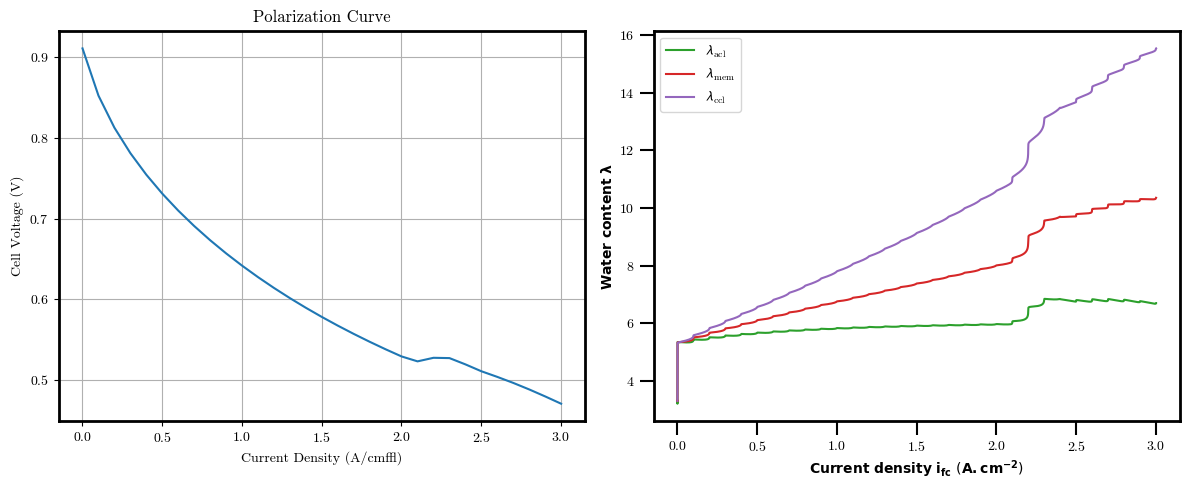

<Figure size 640x480 with 0 Axes>

✅ Sample 1 valid: {'Tfc': 353.526, 'Pa_des': 240000.0, 'Pc_des': 200000.0, 'Sc': 2.6, 'Phi_c_des': 0.44, 'epsilon_gdl': 0.701, 'tau': 1.316, 'epsilon_mc': 0.295, 'epsilon_c': 0.292, 'e': 5, 'Re': 5.7e-07, 'i0_c_ref': 2.79, 'kappa_co': 31.581, 'kappa_c': 1.61, 'a_slim': 0.211, 'b_slim': 0.368, 'a_switch': 0.842, 'Sa': 1.2, 'Phi_a_des': 0.4}


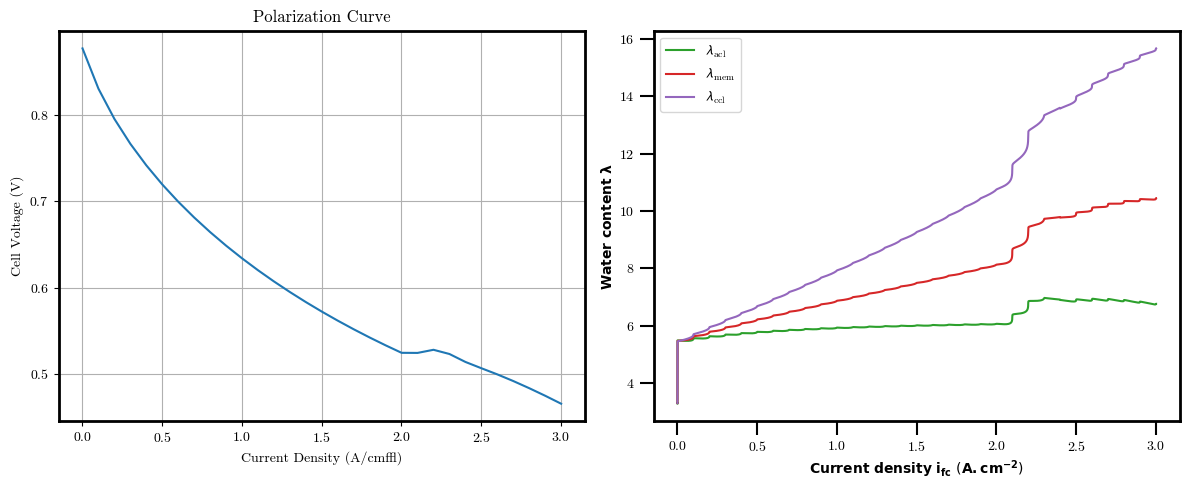

<Figure size 640x480 with 0 Axes>

✅ Sample 2 valid: {'Tfc': 353.526, 'Pa_des': 240000.0, 'Pc_des': 200000.0, 'Sc': 2.6, 'Phi_c_des': 0.44, 'epsilon_gdl': 0.701, 'tau': 1.789, 'epsilon_mc': 0.295, 'epsilon_c': 0.292, 'e': 5, 'Re': 5.7e-07, 'i0_c_ref': 2.79, 'kappa_co': 31.581, 'kappa_c': 1.61, 'a_slim': 0.211, 'b_slim': 0.368, 'a_switch': 0.842, 'Sa': 1.2, 'Phi_a_des': 0.4}


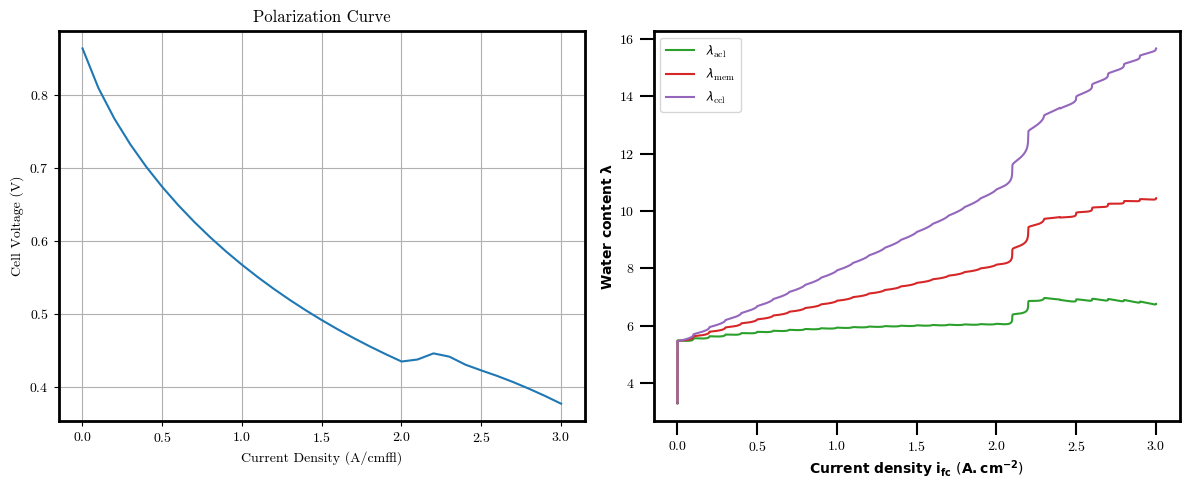

<Figure size 640x480 with 0 Axes>

✅ Sample 3 valid: {'Tfc': 353.526, 'Pa_des': 240000.0, 'Pc_des': 200000.0, 'Sc': 2.6, 'Phi_c_des': 0.44, 'epsilon_gdl': 0.701, 'tau': 1.789, 'epsilon_mc': 0.295, 'epsilon_c': 0.292, 'e': 5, 'Re': 5.7e-07, 'i0_c_ref': 2.79, 'kappa_co': 21.057, 'kappa_c': 1.61, 'a_slim': 0.211, 'b_slim': 0.842, 'a_switch': 0.526, 'Sa': 1.2, 'Phi_a_des': 0.4}


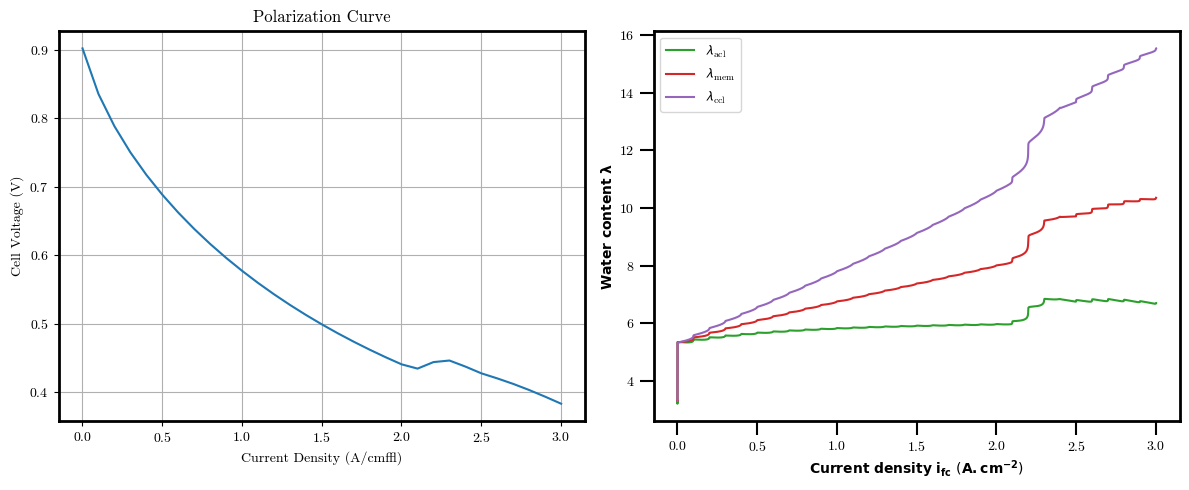

<Figure size 640x480 with 0 Axes>

✅ Sample 4 valid: {'Tfc': 353.526, 'Pa_des': 240000.0, 'Pc_des': 200000.0, 'Sc': 2.6, 'Phi_c_des': 0.44, 'epsilon_gdl': 0.701, 'tau': 1.316, 'epsilon_mc': 0.295, 'epsilon_c': 0.292, 'e': 5, 'Re': 5.7e-07, 'i0_c_ref': 2.79, 'kappa_co': 31.581, 'kappa_c': 1.61, 'a_slim': 0.3668, 'b_slim': 0.368, 'a_switch': 0.526, 'Sa': 1.2, 'Phi_a_des': 0.4}


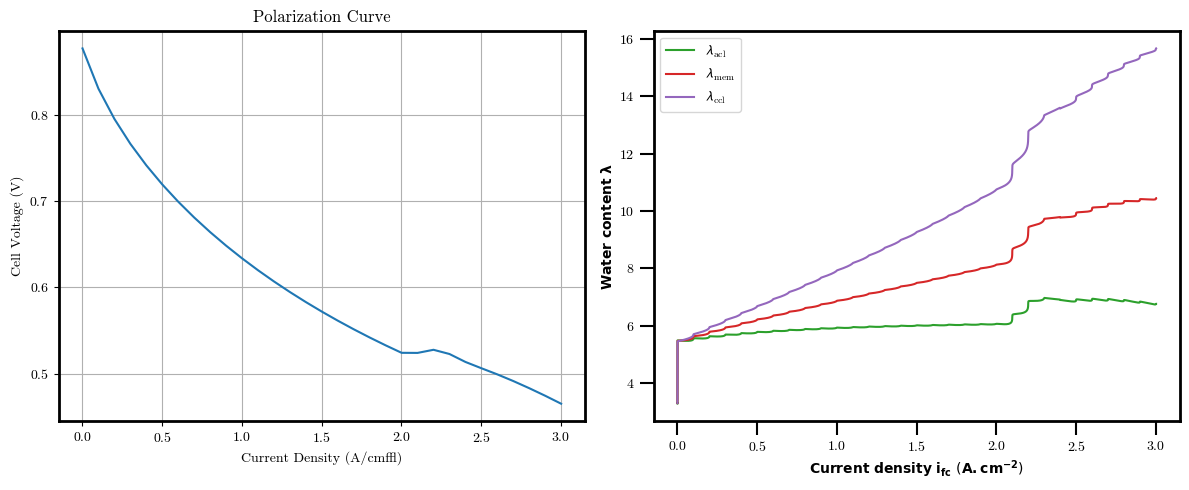

<Figure size 640x480 with 0 Axes>

✅ Sample 5 valid: {'Tfc': 353.526, 'Pa_des': 240000.0, 'Pc_des': 200000.0, 'Sc': 2.6, 'Phi_c_des': 0.44, 'epsilon_gdl': 0.701, 'tau': 1.789, 'epsilon_mc': 0.334, 'epsilon_c': 0.292, 'e': 5, 'Re': 5.7e-07, 'i0_c_ref': 2.79, 'kappa_co': 21.057, 'kappa_c': 1.61, 'a_slim': 0.211, 'b_slim': 0.368, 'a_switch': 0.526, 'Sa': 1.2, 'Phi_a_des': 0.4}


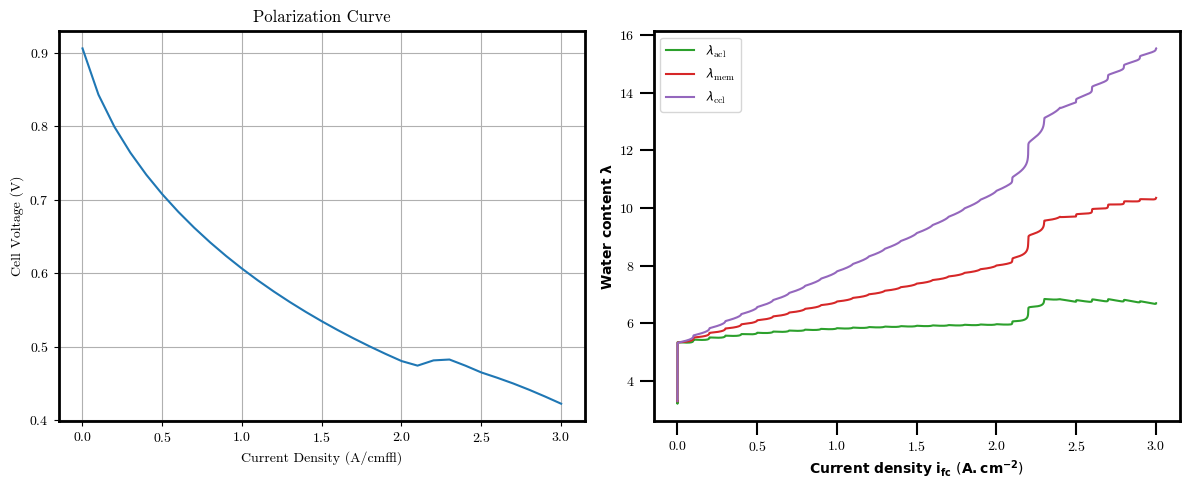

<Figure size 640x480 with 0 Axes>

✅ Sample 6 valid: {'Tfc': 353.526, 'Pa_des': 240000.0, 'Pc_des': 200000.0, 'Sc': 2.6, 'Phi_c_des': 0.44, 'epsilon_gdl': 0.701, 'tau': 1.316, 'epsilon_mc': 0.295, 'epsilon_c': 0.292, 'e': 5, 'Re': 5.7e-07, 'i0_c_ref': 2.79, 'kappa_co': 31.581, 'kappa_c': 1.61, 'a_slim': 0.211, 'b_slim': 0.842, 'a_switch': 0.526, 'Sa': 1.2, 'Phi_a_des': 0.4}


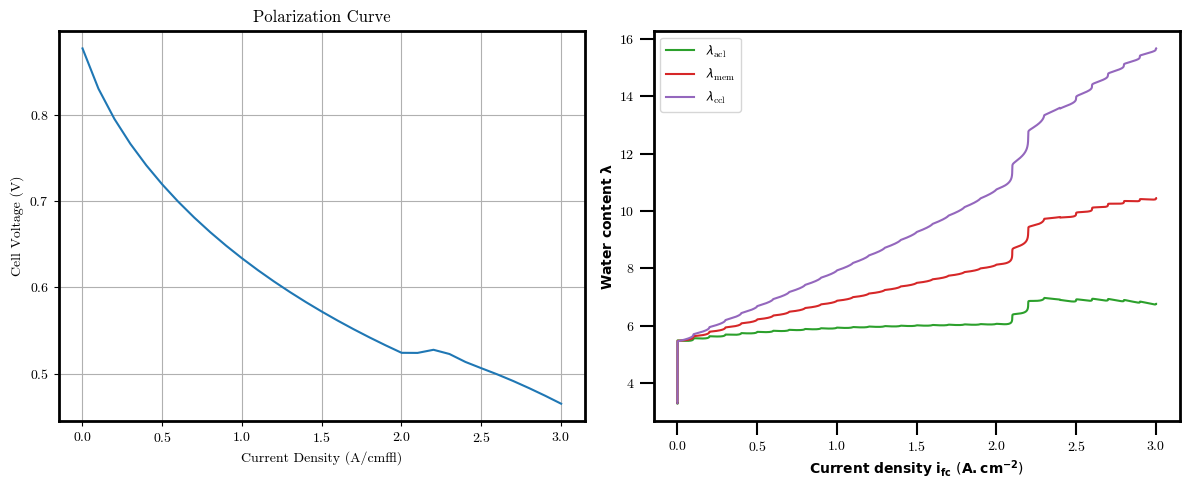

<Figure size 640x480 with 0 Axes>

✅ Sample 7 valid: {'Tfc': 353.526, 'Pa_des': 240000.0, 'Pc_des': 200000.0, 'Sc': 2.6, 'Phi_c_des': 0.44, 'epsilon_gdl': 0.701, 'tau': 1.789, 'epsilon_mc': 0.334, 'epsilon_c': 0.292, 'e': 5, 'Re': 5.7e-07, 'i0_c_ref': 2.79, 'kappa_co': 21.057, 'kappa_c': 1.61, 'a_slim': 0.3668, 'b_slim': 0.368, 'a_switch': 0.842, 'Sa': 1.2, 'Phi_a_des': 0.4}


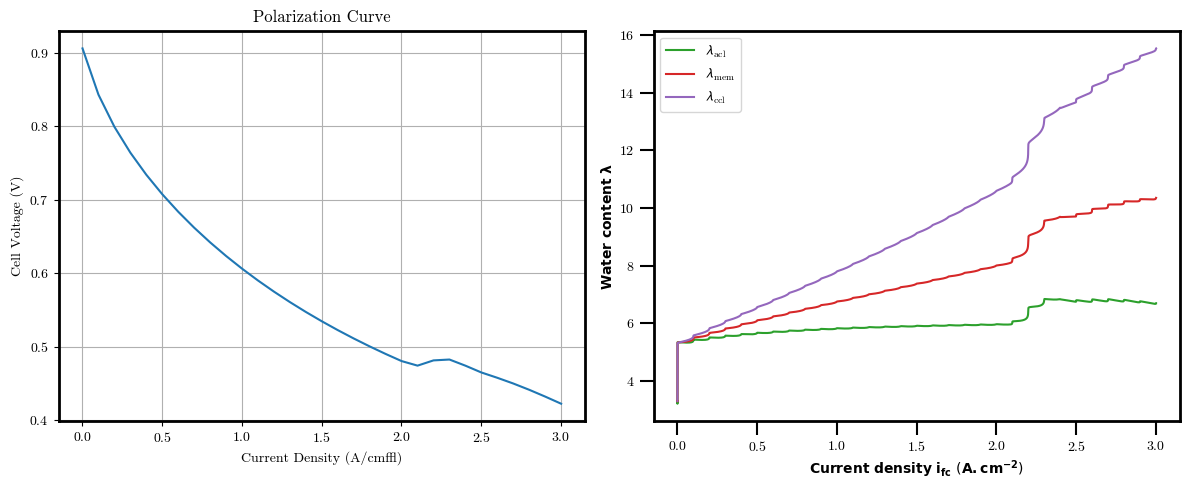

<Figure size 640x480 with 0 Axes>

✅ Sample 8 valid: {'Tfc': 353.526, 'Pa_des': 240000.0, 'Pc_des': 200000.0, 'Sc': 2.6, 'Phi_c_des': 0.44, 'epsilon_gdl': 0.701, 'tau': 1.316, 'epsilon_mc': 0.295, 'epsilon_c': 0.245, 'e': 5, 'Re': 5.7e-07, 'i0_c_ref': 2.79, 'kappa_co': 31.581, 'kappa_c': 1.61, 'a_slim': 0.211, 'b_slim': 0.842, 'a_switch': 0.526, 'Sa': 1.2, 'Phi_a_des': 0.4}


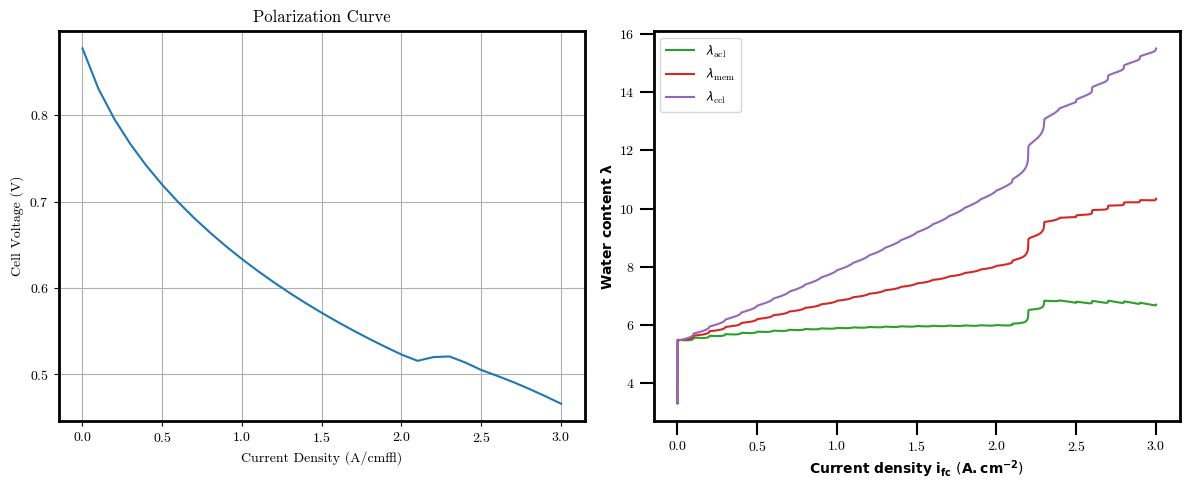

<Figure size 640x480 with 0 Axes>

✅ Sample 9 valid: {'Tfc': 353.526, 'Pa_des': 240000.0, 'Pc_des': 200000.0, 'Sc': 2.6, 'Phi_c_des': 0.44, 'epsilon_gdl': 0.701, 'tau': 1.316, 'epsilon_mc': 0.334, 'epsilon_c': 0.245, 'e': 5, 'Re': 5.7e-07, 'i0_c_ref': 2.79, 'kappa_co': 31.581, 'kappa_c': 1.61, 'a_slim': 0.3668, 'b_slim': 0.842, 'a_switch': 0.526, 'Sa': 1.2, 'Phi_a_des': 0.4}


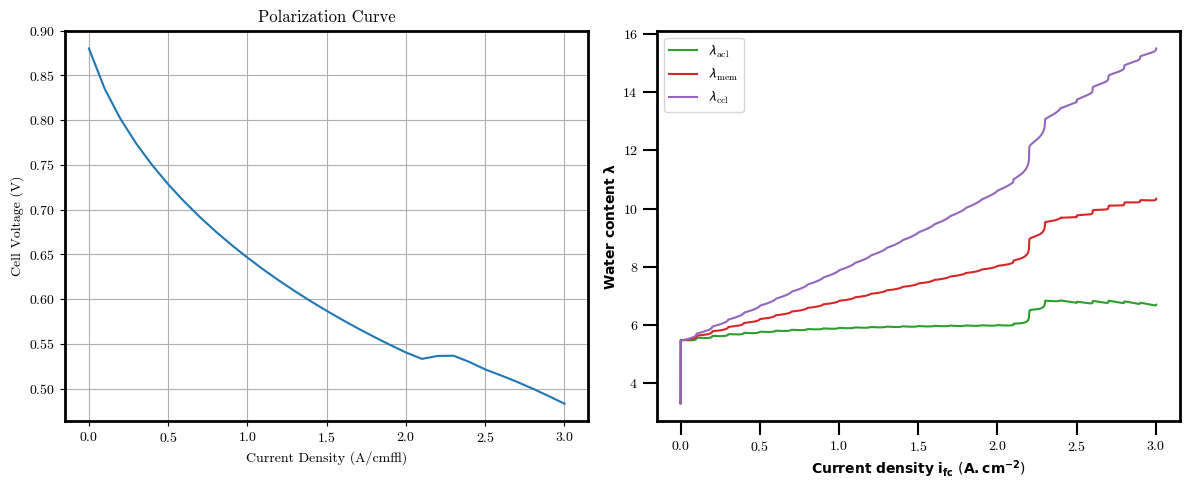

<Figure size 640x480 with 0 Axes>

✅ Sample 10 valid: {'Tfc': 353.526, 'Pa_des': 240000.0, 'Pc_des': 200000.0, 'Sc': 2.6, 'Phi_c_des': 0.44, 'epsilon_gdl': 0.701, 'tau': 1.316, 'epsilon_mc': 0.295, 'epsilon_c': 0.292, 'e': 5, 'Re': 5.7e-07, 'i0_c_ref': 2.79, 'kappa_co': 31.581, 'kappa_c': 1.61, 'a_slim': 0.3668, 'b_slim': 0.368, 'a_switch': 0.842, 'Sa': 1.2, 'Phi_a_des': 0.4}


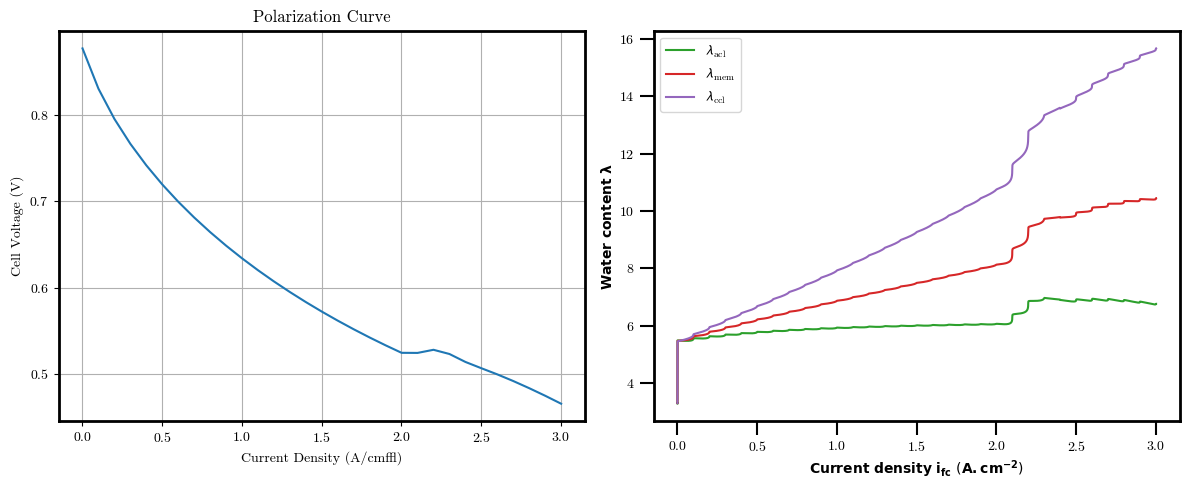

<Figure size 640x480 with 0 Axes>

✅ Sample 11 valid: {'Tfc': 353.526, 'Pa_des': 240000.0, 'Pc_des': 200000.0, 'Sc': 2.6, 'Phi_c_des': 0.44, 'epsilon_gdl': 0.701, 'tau': 1.316, 'epsilon_mc': 0.295, 'epsilon_c': 0.245, 'e': 5, 'Re': 5.7e-07, 'i0_c_ref': 2.79, 'kappa_co': 31.581, 'kappa_c': 1.61, 'a_slim': 0.211, 'b_slim': 0.368, 'a_switch': 0.842, 'Sa': 1.2, 'Phi_a_des': 0.4}


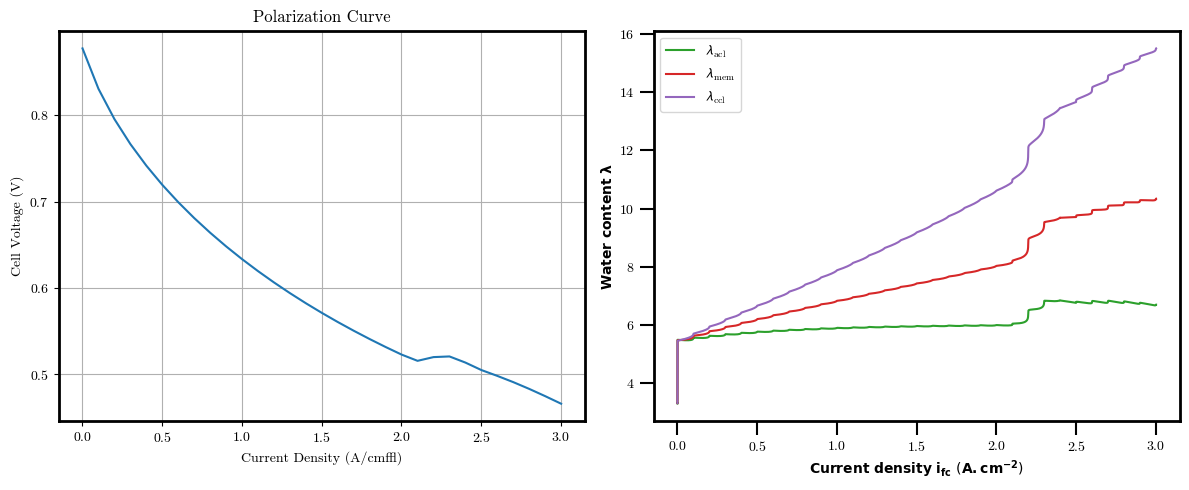

<Figure size 640x480 with 0 Axes>

✅ Sample 12 valid: {'Tfc': 353.526, 'Pa_des': 240000.0, 'Pc_des': 200000.0, 'Sc': 2.6, 'Phi_c_des': 0.44, 'epsilon_gdl': 0.701, 'tau': 1.789, 'epsilon_mc': 0.295, 'epsilon_c': 0.245, 'e': 5, 'Re': 5.7e-07, 'i0_c_ref': 2.79, 'kappa_co': 31.581, 'kappa_c': 1.61, 'a_slim': 0.3668, 'b_slim': 0.368, 'a_switch': 0.526, 'Sa': 1.2, 'Phi_a_des': 0.4}


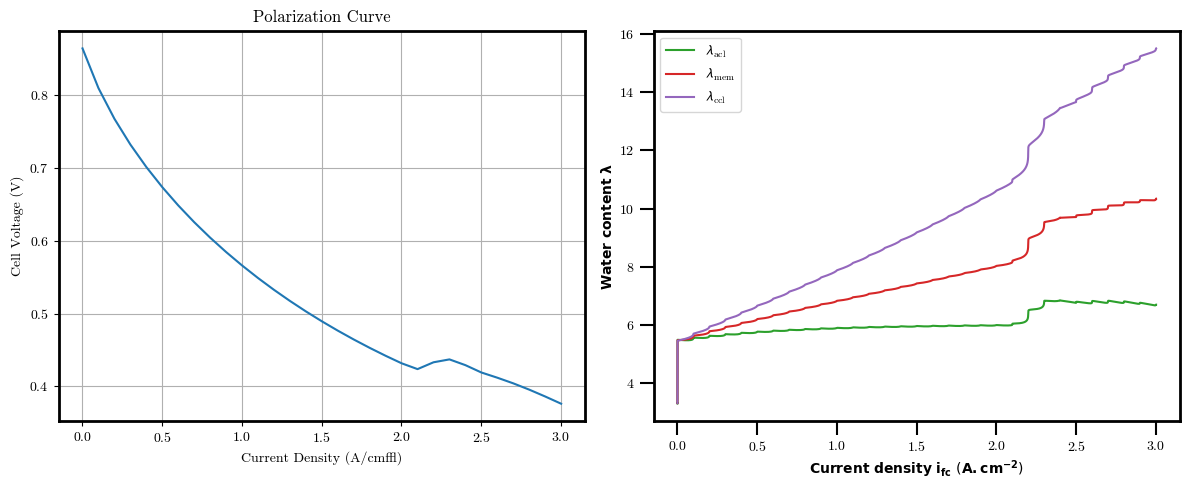

<Figure size 640x480 with 0 Axes>

✅ Sample 13 valid: {'Tfc': 353.526, 'Pa_des': 240000.0, 'Pc_des': 200000.0, 'Sc': 2.6, 'Phi_c_des': 0.44, 'epsilon_gdl': 0.701, 'tau': 1.789, 'epsilon_mc': 0.295, 'epsilon_c': 0.245, 'e': 5, 'Re': 5.7e-07, 'i0_c_ref': 2.79, 'kappa_co': 21.057, 'kappa_c': 1.61, 'a_slim': 0.211, 'b_slim': 0.842, 'a_switch': 0.842, 'Sa': 1.2, 'Phi_a_des': 0.4}


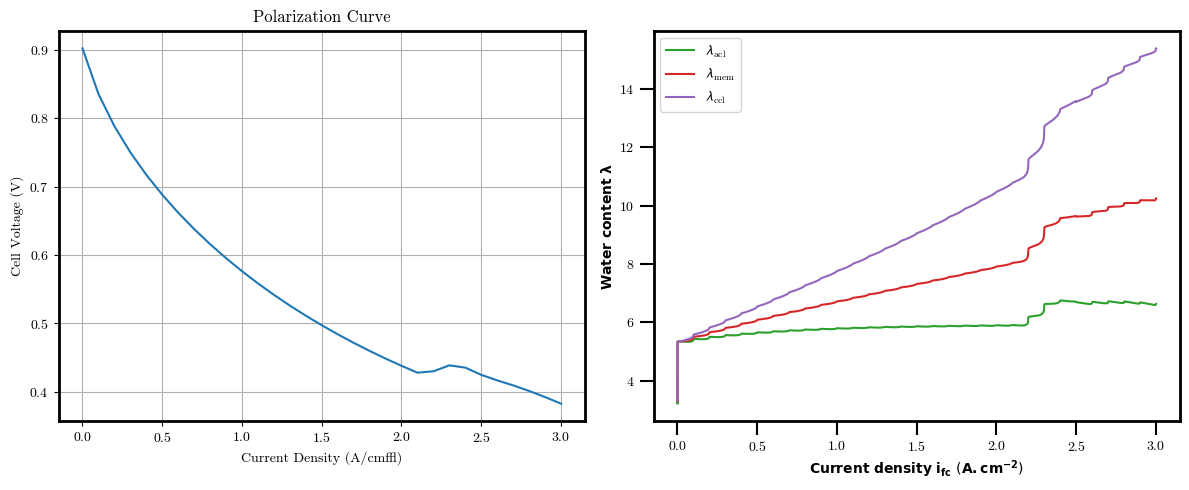

<Figure size 640x480 with 0 Axes>

✅ Sample 14 valid: {'Tfc': 353.526, 'Pa_des': 240000.0, 'Pc_des': 200000.0, 'Sc': 2.6, 'Phi_c_des': 0.44, 'epsilon_gdl': 0.701, 'tau': 1.789, 'epsilon_mc': 0.295, 'epsilon_c': 0.292, 'e': 5, 'Re': 5.7e-07, 'i0_c_ref': 2.79, 'kappa_co': 21.057, 'kappa_c': 1.61, 'a_slim': 0.211, 'b_slim': 0.368, 'a_switch': 0.526, 'Sa': 1.2, 'Phi_a_des': 0.4}


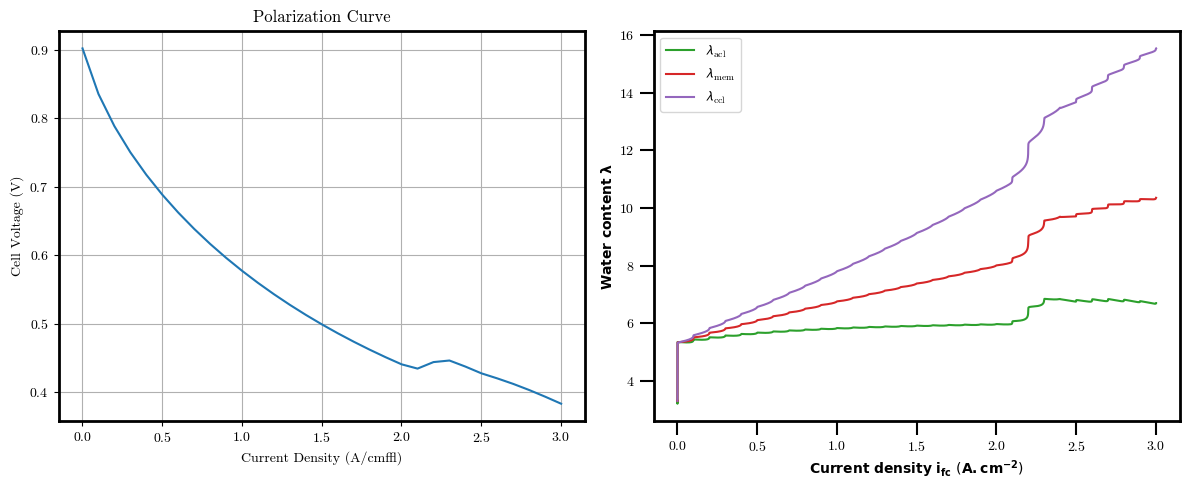

<Figure size 640x480 with 0 Axes>

✅ Sample 15 valid: {'Tfc': 353.526, 'Pa_des': 240000.0, 'Pc_des': 200000.0, 'Sc': 2.6, 'Phi_c_des': 0.44, 'epsilon_gdl': 0.701, 'tau': 1.789, 'epsilon_mc': 0.295, 'epsilon_c': 0.245, 'e': 5, 'Re': 5.7e-07, 'i0_c_ref': 2.79, 'kappa_co': 21.057, 'kappa_c': 1.61, 'a_slim': 0.3668, 'b_slim': 0.842, 'a_switch': 0.526, 'Sa': 1.2, 'Phi_a_des': 0.4}


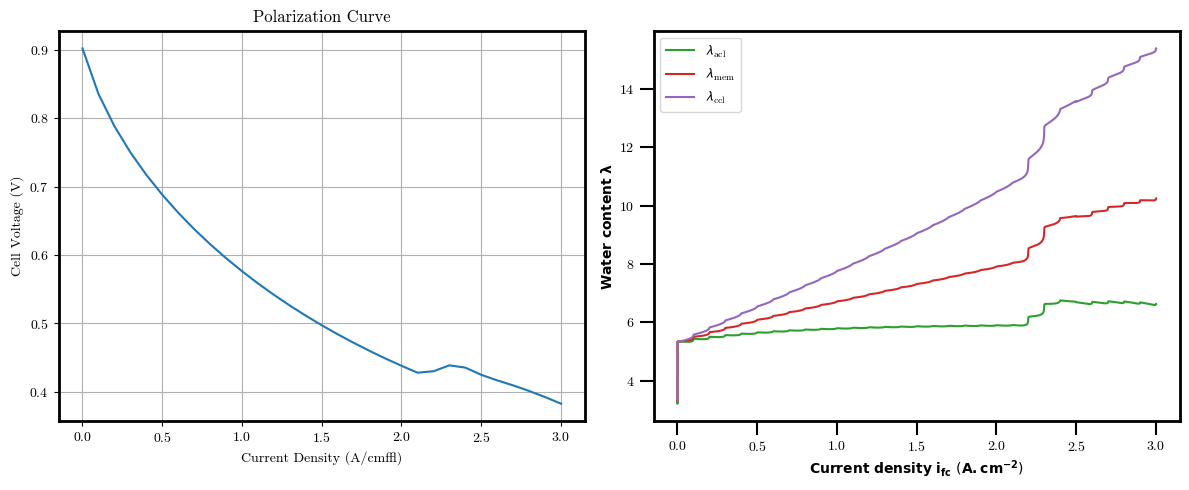

<Figure size 640x480 with 0 Axes>

In [180]:
plot_alpha_curves(sampled_parameters=data_rev3_filt_grow_rev_alpha.to_dict(orient='records'), fixed_parameters=build_fixed_parameters())